# Rental Rates of Major Metro Markets
## Machine Learning Model based off data provided by Zillow.com

Zillow Observed Rent Index (ZORI): A smoothed measure of the typical observed market rate rent across a given region. ZORI is a repeat-rent index that is weighted to the rental housing stock to ensure representativeness across the entire market, not just those homes currently listed for-rent. The index is dollar-denominated by computing the mean of listed rents that fall into the 40th to 60th percentile range for all homes and apartments in a given region, which is once again weighted to reflect the rental housing stock. Details available in ZORI methodology.
https://www.zillow.com/research/methodology-zori-repeat-rent-27092/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DS-CodingDojoColab/Project2/Zip_ZORI_AllHomesPlusMultifamily_SSA.csv')
df.tail()

,RegionID,RegionName,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
2258,61618,10004,8842,"New York, NY",2836.0,2863.0,2890.0,2916.0,2942.0,2968.0,2994.0,3020.0,3046.0,3072.0,3093.0,3114.0,3135.0,3154.0,3173.0,3192.0,3214.0,3236.0,3258.0,3268.0,3279.0,3290.0,3291.0,3292.0,3294.0,3289.0,3284.0,3280.0,3270.0,3260.0,3250.0,3247.0,3244.0,3241.0,3240.0,3240.0,...,3210.0,3207.0,3204.0,3202.0,3200.0,3203.0,3205.0,3208.0,3211.0,3214.0,3217.0,3218.0,3219.0,3219.0,3224.0,3229.0,3233.0,3240.0,3247.0,3254.0,3263.0,3273.0,3282.0,3290.0,3298.0,3306.0,3299.0,3293.0,3286.0,3247.0,3207.0,3168.0,3118.0,3068.0,3018.0,2965.0,2913.0,2860.0,2803.0,2747.0
2259,58622,2108,8986,"Boston, MA",2392.0,2393.0,2394.0,2395.0,2396.0,2398.0,2400.0,2402.0,2403.0,2405.0,2412.0,2418.0,2425.0,2436.0,2446.0,2457.0,2463.0,2468.0,2474.0,2478.0,2481.0,2485.0,2490.0,2495.0,2500.0,2503.0,2506.0,2509.0,2516.0,2522.0,2529.0,2539.0,2549.0,2559.0,2565.0,2572.0,...,2585.0,2582.0,2582.0,2582.0,2581.0,2586.0,2590.0,2594.0,2597.0,2599.0,2602.0,2607.0,2611.0,2616.0,2626.0,2636.0,2646.0,2657.0,2667.0,2678.0,2694.0,2710.0,2725.0,2745.0,2764.0,2783.0,2788.0,2793.0,2798.0,2787.0,2776.0,2765.0,2752.0,2739.0,2726.0,2711.0,2696.0,2681.0,2664.0,2647.0
2260,72525,33306,9047,"Miami-Fort Lauderdale, FL",1105.0,1121.0,1137.0,1153.0,1167.0,1182.0,NaN,1209.0,1222.0,1235.0,NaN,1250.0,1257.0,1258.0,1259.0,NaN,1255.0,1250.0,1244.0,NaN,NaN,1240.0,NaN,NaN,1252.0,1255.0,1258.0,1260.0,1265.0,1270.0,1275.0,1281.0,1287.0,NaN,NaN,1300.0,...,1318.0,1323.0,1327.0,1332.0,1336.0,1342.0,1348.0,1354.0,1361.0,1368.0,1374.0,1380.0,NaN,NaN,1400.0,1410.0,NaN,1432.0,1443.0,1455.0,1465.0,1474.0,1484.0,1488.0,1491.0,1495.0,1493.0,1491.0,1489.0,1491.0,NaN,1497.0,1500.0,1502.0,1505.0,1507.0,1510.0,1513.0,1516.0,NaN
2261,58624,2110,9469,"Boston, MA",4037.0,4030.0,4023.0,4016.0,NaN,4006.0,4001.0,NaN,4006.0,NaN,NaN,NaN,4015.0,NaN,4087.0,4124.0,4187.0,4250.0,4313.0,NaN,4356.0,NaN,4386.0,NaN,4403.0,4417.0,4430.0,4444.0,4467.0,4490.0,4513.0,4550.0,4586.0,4622.0,NaN,4666.0,...,NaN,4557.0,4539.0,4522.0,4504.0,4486.0,4469.0,4452.0,4456.0,4460.0,4463.0,4478.0,4492.0,4507.0,4518.0,4529.0,4540.0,4556.0,4572.0,4587.0,4606.0,4624.0,4642.0,4636.0,4629.0,4623.0,4601.0,4580.0,4558.0,4512.0,NaN,NaN,4366.0,4313.0,4260.0,4204.0,4149.0,4093.0,4037.0,3980.0
2262,66128,20004,9592,"Washington, DC",NaN,NaN,2297.0,2308.0,NaN,2329.0,NaN,2349.0,2359.0,NaN,NaN,NaN,2380.0,2377.0,2375.0,2372.0,2373.0,2373.0,2374.0,2375.0,2377.0,NaN,2377.0,2374.0,NaN,2379.0,2385.0,2391.0,2399.0,2408.0,2416.0,2424.0,2432.0,2440.0,2452.0,2465.0,...,2473.0,2465.0,2454.0,2443.0,2432.0,2423.0,2415.0,2406.0,2401.0,2397.0,2392.0,2394.0,2395.0,2396.0,2399.0,2401.0,2404.0,2405.0,2407.0,2408.0,2412.0,2417.0,2421.0,2425.0,2429.0,2434.0,2438.0,2441.0,2445.0,2444.0,2443.0,2441.0,2436.0,2431.0,2426.0,2420.0,2414.0,2408.0,2401.0,2394.0


I can already see in the last 5 rows alone that there are some NaN null values... let's get some basic info and find null values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    2263 non-null   int64  
 1   RegionName  2263 non-null   int64  
 2   SizeRank    2263 non-null   int64  
 3   MsaName     2263 non-null   object 
 4   2014-01     1726 non-null   float64
 5   2014-02     1785 non-null   float64
 6   2014-03     1740 non-null   float64
 7   2014-04     1961 non-null   float64
 8   2014-05     2030 non-null   float64
 9   2014-06     2094 non-null   float64
 10  2014-07     2129 non-null   float64
 11  2014-08     2119 non-null   float64
 12  2014-09     2113 non-null   float64
 13  2014-10     2062 non-null   float64
 14  2014-11     2022 non-null   float64
 15  2014-12     2027 non-null   float64
 16  2015-01     2066 non-null   float64
 17  2015-02     2060 non-null   float64
 18  2015-03     2144 non-null   float64
 19  2015-04     2146 non-null  

It appears that there are a lot of missing values for each month's rent reporting, so we're going to want to impute those.  Given that we generally know some value for a given location's rent before or after a missing month, it's a safe assumption we can fill the missing values with the median of before and after.

https://www.geeksforgeeks.org/python-pandas-dataframe-interpolate/



In [ ]:
df_sort = df.sort_values(by=['RegionName'], axis=0)
df_sort.head()

,RegionID,RegionName,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
774,58477,1752,1303,"Boston, MA",1265.0,1269.0,1272.0,1276.0,1280.0,1283.0,1287.0,1291.0,1295.0,1298.0,1302.0,1306.0,1311.0,1315.0,1319.0,1323.0,1328.0,1333.0,1338.0,1344.0,1350.0,1357.0,1364.0,1371.0,1378.0,1384.0,1391.0,1397.0,1402.0,1408.0,1413.0,1418.0,1422.0,1427.0,1432.0,1436.0,...,1481.0,1487.0,1493.0,1500.0,1507.0,1515.0,1523.0,1531.0,1542.0,1552.0,1563.0,1573.0,1584.0,1595.0,1604.0,1613.0,1623.0,1631.0,1639.0,1647.0,1652.0,1656.0,1660.0,1661.0,1663.0,1664.0,1664.0,1665.0,1665.0,1666.0,1666.0,1667.0,1667.0,1668.0,1668.0,1668.0,1669.0,1669.0,1670.0,1671.0
1143,58481,1760,2041,"Boston, MA",1752.0,1750.0,1748.0,1746.0,1744.0,1741.0,1739.0,1737.0,1735.0,NaN,1734.0,1735.0,1736.0,1735.0,1735.0,1735.0,1734.0,1734.0,1734.0,1738.0,1742.0,1746.0,1752.0,1759.0,1765.0,1770.0,1774.0,1778.0,1776.0,1773.0,1771.0,1769.0,1768.0,1767.0,1769.0,1771.0,...,1810.0,1814.0,1819.0,1824.0,1829.0,1838.0,1847.0,1857.0,1869.0,1881.0,1893.0,1903.0,1913.0,1922.0,1926.0,1930.0,1934.0,1935.0,1935.0,1936.0,1939.0,1943.0,1947.0,1953.0,1960.0,1966.0,1971.0,1975.0,1979.0,1978.0,1977.0,1976.0,1973.0,1970.0,1966.0,1962.0,1957.0,1953.0,1947.0,1942.0
857,58489,1801,1445,"Boston, MA",1460.0,NaN,NaN,1520.0,1539.0,1558.0,1577.0,1597.0,1616.0,NaN,1651.0,1667.0,1682.0,NaN,1703.0,1713.0,1721.0,1730.0,1738.0,1747.0,1756.0,1765.0,1769.0,1773.0,1777.0,1782.0,1788.0,1793.0,1804.0,1815.0,1825.0,1835.0,1845.0,1856.0,1867.0,1879.0,...,1943.0,1948.0,1954.0,1959.0,1965.0,1973.0,1981.0,1989.0,1999.0,2009.0,2020.0,2029.0,2038.0,2047.0,2054.0,2061.0,2068.0,2073.0,2078.0,2083.0,2088.0,2092.0,2097.0,2100.0,2104.0,2108.0,2109.0,2111.0,2113.0,2108.0,2102.0,2097.0,2088.0,2079.0,2070.0,2060.0,2051.0,2041.0,2030.0,2020.0
1773,58517,1851,3728,"Boston, MA",995.0,1005.0,1014.0,1024.0,1033.0,1042.0,1051.0,1060.0,1069.0,1078.0,1083.0,1088.0,1093.0,NaN,1101.0,NaN,1112.0,1120.0,1127.0,1137.0,1146.0,1156.0,1167.0,1177.0,1187.0,1195.0,NaN,1212.0,1217.0,1222.0,1226.0,1229.0,1232.0,1235.0,NaN,1244.0,...,1283.0,1287.0,1294.0,1300.0,1306.0,1314.0,1323.0,1331.0,1339.0,1348.0,1357.0,1364.0,1371.0,1377.0,1381.0,1385.0,1389.0,1391.0,1393.0,1395.0,1397.0,1399.0,1401.0,1405.0,1409.0,1413.0,1416.0,1420.0,1423.0,1426.0,1428.0,1430.0,1433.0,1436.0,1439.0,1442.0,1444.0,1447.0,1450.0,1452.0
1178,58518,1852,2122,"Boston, MA",1065.0,NaN,1101.0,1118.0,1135.0,1152.0,1168.0,1184.0,1200.0,NaN,1226.0,1236.0,NaN,1252.0,1257.0,1262.0,NaN,1274.0,1279.0,1287.0,1295.0,1303.0,NaN,1319.0,1328.0,1335.0,1342.0,1349.0,1355.0,1360.0,1365.0,1371.0,1376.0,1381.0,1388.0,1394.0,...,1437.0,1442.0,1449.0,1456.0,1463.0,1474.0,1485.0,1495.0,1507.0,1518.0,1530.0,1540.0,1550.0,1560.0,1567.0,1573.0,1579.0,1583.0,1587.0,1590.0,1594.0,1597.0,1601.0,1606.0,1610.0,1615.0,1619.0,1624.0,1628.0,1633.0,1638.0,1643.0,1647.0,1650.0,1654.0,1657.0,1661.0,1664.0,1667.0,1671.0


In [ ]:
# We'll rename RegionName to Zip Code since it's very confusing.  The number corresponds with the zip code.
df_sort.rename(columns = {'RegionName' : 'Zip Code'}, inplace=True)
df_sort.head()

,RegionID,Zip Code,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
774,58477,1752,1303,"Boston, MA",1265.0,1269.0,1272.0,1276.0,1280.0,1283.0,1287.0,1291.0,1295.0,1298.0,1302.0,1306.0,1311.0,1315.0,1319.0,1323.0,1328.0,1333.0,1338.0,1344.0,1350.0,1357.0,1364.0,1371.0,1378.0,1384.0,1391.0,1397.0,1402.0,1408.0,1413.0,1418.0,1422.0,1427.0,1432.0,1436.0,...,1481.0,1487.0,1493.0,1500.0,1507.0,1515.0,1523.0,1531.0,1542.0,1552.0,1563.0,1573.0,1584.0,1595.0,1604.0,1613.0,1623.0,1631.0,1639.0,1647.0,1652.0,1656.0,1660.0,1661.0,1663.0,1664.0,1664.0,1665.0,1665.0,1666.0,1666.0,1667.0,1667.0,1668.0,1668.0,1668.0,1669.0,1669.0,1670.0,1671.0
1143,58481,1760,2041,"Boston, MA",1752.0,1750.0,1748.0,1746.0,1744.0,1741.0,1739.0,1737.0,1735.0,NaN,1734.0,1735.0,1736.0,1735.0,1735.0,1735.0,1734.0,1734.0,1734.0,1738.0,1742.0,1746.0,1752.0,1759.0,1765.0,1770.0,1774.0,1778.0,1776.0,1773.0,1771.0,1769.0,1768.0,1767.0,1769.0,1771.0,...,1810.0,1814.0,1819.0,1824.0,1829.0,1838.0,1847.0,1857.0,1869.0,1881.0,1893.0,1903.0,1913.0,1922.0,1926.0,1930.0,1934.0,1935.0,1935.0,1936.0,1939.0,1943.0,1947.0,1953.0,1960.0,1966.0,1971.0,1975.0,1979.0,1978.0,1977.0,1976.0,1973.0,1970.0,1966.0,1962.0,1957.0,1953.0,1947.0,1942.0
857,58489,1801,1445,"Boston, MA",1460.0,NaN,NaN,1520.0,1539.0,1558.0,1577.0,1597.0,1616.0,NaN,1651.0,1667.0,1682.0,NaN,1703.0,1713.0,1721.0,1730.0,1738.0,1747.0,1756.0,1765.0,1769.0,1773.0,1777.0,1782.0,1788.0,1793.0,1804.0,1815.0,1825.0,1835.0,1845.0,1856.0,1867.0,1879.0,...,1943.0,1948.0,1954.0,1959.0,1965.0,1973.0,1981.0,1989.0,1999.0,2009.0,2020.0,2029.0,2038.0,2047.0,2054.0,2061.0,2068.0,2073.0,2078.0,2083.0,2088.0,2092.0,2097.0,2100.0,2104.0,2108.0,2109.0,2111.0,2113.0,2108.0,2102.0,2097.0,2088.0,2079.0,2070.0,2060.0,2051.0,2041.0,2030.0,2020.0
1773,58517,1851,3728,"Boston, MA",995.0,1005.0,1014.0,1024.0,1033.0,1042.0,1051.0,1060.0,1069.0,1078.0,1083.0,1088.0,1093.0,NaN,1101.0,NaN,1112.0,1120.0,1127.0,1137.0,1146.0,1156.0,1167.0,1177.0,1187.0,1195.0,NaN,1212.0,1217.0,1222.0,1226.0,1229.0,1232.0,1235.0,NaN,1244.0,...,1283.0,1287.0,1294.0,1300.0,1306.0,1314.0,1323.0,1331.0,1339.0,1348.0,1357.0,1364.0,1371.0,1377.0,1381.0,1385.0,1389.0,1391.0,1393.0,1395.0,1397.0,1399.0,1401.0,1405.0,1409.0,1413.0,1416.0,1420.0,1423.0,1426.0,1428.0,1430.0,1433.0,1436.0,1439.0,1442.0,1444.0,1447.0,1450.0,1452.0
1178,58518,1852,2122,"Boston, MA",1065.0,NaN,1101.0,1118.0,1135.0,1152.0,1168.0,1184.0,1200.0,NaN,1226.0,1236.0,NaN,1252.0,1257.0,1262.0,NaN,1274.0,1279.0,1287.0,1295.0,1303.0,NaN,1319.0,1328.0,1335.0,1342.0,1349.0,1355.0,1360.0,1365.0,1371.0,1376.0,1381.0,1388.0,1394.0,...,1437.0,1442.0,1449.0,1456.0,1463.0,1474.0,1485.0,1495.0,1507.0,1518.0,1530.0,1540.0,1550.0,1560.0,1567.0,1573.0,1579.0,1583.0,1587.0,1590.0,1594.0,1597.0,1601.0,1606.0,1610.0,1615.0,1619.0,1624.0,1628.0,1633.0,1638.0,1643.0,1647.0,1650.0,1654.0,1657.0,1661.0,1664.0,1667.0,1671.0


The Region ID and Size Rank are not really something we need at the moment, since we have a way to identify each row by Zip Code and MsaName, so we'll drop them out of the DF.

In [ ]:
df_drop = df_sort.drop(['RegionID','SizeRank'], axis=1);
df_drop.head()

,Zip Code,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
774,1752,"Boston, MA",1265.0,1269.0,1272.0,1276.0,1280.0,1283.0,1287.0,1291.0,1295.0,1298.0,1302.0,1306.0,1311.0,1315.0,1319.0,1323.0,1328.0,1333.0,1338.0,1344.0,1350.0,1357.0,1364.0,1371.0,1378.0,1384.0,1391.0,1397.0,1402.0,1408.0,1413.0,1418.0,1422.0,1427.0,1432.0,1436.0,1440.0,1445.0,...,1481.0,1487.0,1493.0,1500.0,1507.0,1515.0,1523.0,1531.0,1542.0,1552.0,1563.0,1573.0,1584.0,1595.0,1604.0,1613.0,1623.0,1631.0,1639.0,1647.0,1652.0,1656.0,1660.0,1661.0,1663.0,1664.0,1664.0,1665.0,1665.0,1666.0,1666.0,1667.0,1667.0,1668.0,1668.0,1668.0,1669.0,1669.0,1670.0,1671.0
1143,1760,"Boston, MA",1752.0,1750.0,1748.0,1746.0,1744.0,1741.0,1739.0,1737.0,1735.0,NaN,1734.0,1735.0,1736.0,1735.0,1735.0,1735.0,1734.0,1734.0,1734.0,1738.0,1742.0,1746.0,1752.0,1759.0,1765.0,1770.0,1774.0,1778.0,1776.0,1773.0,1771.0,1769.0,1768.0,1767.0,1769.0,1771.0,1772.0,1775.0,...,1810.0,1814.0,1819.0,1824.0,1829.0,1838.0,1847.0,1857.0,1869.0,1881.0,1893.0,1903.0,1913.0,1922.0,1926.0,1930.0,1934.0,1935.0,1935.0,1936.0,1939.0,1943.0,1947.0,1953.0,1960.0,1966.0,1971.0,1975.0,1979.0,1978.0,1977.0,1976.0,1973.0,1970.0,1966.0,1962.0,1957.0,1953.0,1947.0,1942.0
857,1801,"Boston, MA",1460.0,NaN,NaN,1520.0,1539.0,1558.0,1577.0,1597.0,1616.0,NaN,1651.0,1667.0,1682.0,NaN,1703.0,1713.0,1721.0,1730.0,1738.0,1747.0,1756.0,1765.0,1769.0,1773.0,1777.0,1782.0,1788.0,1793.0,1804.0,1815.0,1825.0,1835.0,1845.0,1856.0,1867.0,1879.0,1890.0,1901.0,...,1943.0,1948.0,1954.0,1959.0,1965.0,1973.0,1981.0,1989.0,1999.0,2009.0,2020.0,2029.0,2038.0,2047.0,2054.0,2061.0,2068.0,2073.0,2078.0,2083.0,2088.0,2092.0,2097.0,2100.0,2104.0,2108.0,2109.0,2111.0,2113.0,2108.0,2102.0,2097.0,2088.0,2079.0,2070.0,2060.0,2051.0,2041.0,2030.0,2020.0
1773,1851,"Boston, MA",995.0,1005.0,1014.0,1024.0,1033.0,1042.0,1051.0,1060.0,1069.0,1078.0,1083.0,1088.0,1093.0,NaN,1101.0,NaN,1112.0,1120.0,1127.0,1137.0,1146.0,1156.0,1167.0,1177.0,1187.0,1195.0,NaN,1212.0,1217.0,1222.0,1226.0,1229.0,1232.0,1235.0,NaN,1244.0,1249.0,1254.0,...,1283.0,1287.0,1294.0,1300.0,1306.0,1314.0,1323.0,1331.0,1339.0,1348.0,1357.0,1364.0,1371.0,1377.0,1381.0,1385.0,1389.0,1391.0,1393.0,1395.0,1397.0,1399.0,1401.0,1405.0,1409.0,1413.0,1416.0,1420.0,1423.0,1426.0,1428.0,1430.0,1433.0,1436.0,1439.0,1442.0,1444.0,1447.0,1450.0,1452.0
1178,1852,"Boston, MA",1065.0,NaN,1101.0,1118.0,1135.0,1152.0,1168.0,1184.0,1200.0,NaN,1226.0,1236.0,NaN,1252.0,1257.0,1262.0,NaN,1274.0,1279.0,1287.0,1295.0,1303.0,NaN,1319.0,1328.0,1335.0,1342.0,1349.0,1355.0,1360.0,1365.0,1371.0,1376.0,1381.0,1388.0,1394.0,1401.0,1406.0,...,1437.0,1442.0,1449.0,1456.0,1463.0,1474.0,1485.0,1495.0,1507.0,1518.0,1530.0,1540.0,1550.0,1560.0,1567.0,1573.0,1579.0,1583.0,1587.0,1590.0,1594.0,1597.0,1601.0,1606.0,1610.0,1615.0,1619.0,1624.0,1628.0,1633.0,1638.0,1643.0,1647.0,1650.0,1654.0,1657.0,1661.0,1664.0,1667.0,1671.0


We'll make the zip code the index column now.

In [ ]:
df_drop['Zip Code'] = df_drop['Zip Code'].astype(str)
df_drop.dtypes

Zip Code     object
MsaName      object
2014-01     float64
2014-02     float64
2014-03     float64
             ...   
2020-08     float64
2020-09     float64
2020-10     float64
2020-11     float64
2020-12     float64
Length: 86, dtype: object

In [ ]:
df_drop.set_index('Zip Code', inplace=True)
df_drop.head()

,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
Zip Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1752,"Boston, MA",1265.0,1269.0,1272.0,1276.0,1280.0,1283.0,1287.0,1291.0,1295.0,1298.0,1302.0,1306.0,1311.0,1315.0,1319.0,1323.0,1328.0,1333.0,1338.0,1344.0,1350.0,1357.0,1364.0,1371.0,1378.0,1384.0,1391.0,1397.0,1402.0,1408.0,1413.0,1418.0,1422.0,1427.0,1432.0,1436.0,1440.0,1445.0,1449.0,...,1481.0,1487.0,1493.0,1500.0,1507.0,1515.0,1523.0,1531.0,1542.0,1552.0,1563.0,1573.0,1584.0,1595.0,1604.0,1613.0,1623.0,1631.0,1639.0,1647.0,1652.0,1656.0,1660.0,1661.0,1663.0,1664.0,1664.0,1665.0,1665.0,1666.0,1666.0,1667.0,1667.0,1668.0,1668.0,1668.0,1669.0,1669.0,1670.0,1671.0
1760,"Boston, MA",1752.0,1750.0,1748.0,1746.0,1744.0,1741.0,1739.0,1737.0,1735.0,NaN,1734.0,1735.0,1736.0,1735.0,1735.0,1735.0,1734.0,1734.0,1734.0,1738.0,1742.0,1746.0,1752.0,1759.0,1765.0,1770.0,1774.0,1778.0,1776.0,1773.0,1771.0,1769.0,1768.0,1767.0,1769.0,1771.0,1772.0,1775.0,1778.0,...,1810.0,1814.0,1819.0,1824.0,1829.0,1838.0,1847.0,1857.0,1869.0,1881.0,1893.0,1903.0,1913.0,1922.0,1926.0,1930.0,1934.0,1935.0,1935.0,1936.0,1939.0,1943.0,1947.0,1953.0,1960.0,1966.0,1971.0,1975.0,1979.0,1978.0,1977.0,1976.0,1973.0,1970.0,1966.0,1962.0,1957.0,1953.0,1947.0,1942.0
1801,"Boston, MA",1460.0,NaN,NaN,1520.0,1539.0,1558.0,1577.0,1597.0,1616.0,NaN,1651.0,1667.0,1682.0,NaN,1703.0,1713.0,1721.0,1730.0,1738.0,1747.0,1756.0,1765.0,1769.0,1773.0,1777.0,1782.0,1788.0,1793.0,1804.0,1815.0,1825.0,1835.0,1845.0,1856.0,1867.0,1879.0,1890.0,1901.0,1911.0,...,1943.0,1948.0,1954.0,1959.0,1965.0,1973.0,1981.0,1989.0,1999.0,2009.0,2020.0,2029.0,2038.0,2047.0,2054.0,2061.0,2068.0,2073.0,2078.0,2083.0,2088.0,2092.0,2097.0,2100.0,2104.0,2108.0,2109.0,2111.0,2113.0,2108.0,2102.0,2097.0,2088.0,2079.0,2070.0,2060.0,2051.0,2041.0,2030.0,2020.0
1851,"Boston, MA",995.0,1005.0,1014.0,1024.0,1033.0,1042.0,1051.0,1060.0,1069.0,1078.0,1083.0,1088.0,1093.0,NaN,1101.0,NaN,1112.0,1120.0,1127.0,1137.0,1146.0,1156.0,1167.0,1177.0,1187.0,1195.0,NaN,1212.0,1217.0,1222.0,1226.0,1229.0,1232.0,1235.0,NaN,1244.0,1249.0,1254.0,1259.0,...,1283.0,1287.0,1294.0,1300.0,1306.0,1314.0,1323.0,1331.0,1339.0,1348.0,1357.0,1364.0,1371.0,1377.0,1381.0,1385.0,1389.0,1391.0,1393.0,1395.0,1397.0,1399.0,1401.0,1405.0,1409.0,1413.0,1416.0,1420.0,1423.0,1426.0,1428.0,1430.0,1433.0,1436.0,1439.0,1442.0,1444.0,1447.0,1450.0,1452.0
1852,"Boston, MA",1065.0,NaN,1101.0,1118.0,1135.0,1152.0,1168.0,1184.0,1200.0,NaN,1226.0,1236.0,NaN,1252.0,1257.0,1262.0,NaN,1274.0,1279.0,1287.0,1295.0,1303.0,NaN,1319.0,1328.0,1335.0,1342.0,1349.0,1355.0,1360.0,1365.0,1371.0,1376.0,1381.0,1388.0,1394.0,1401.0,1406.0,1411.0,...,1437.0,1442.0,1449.0,1456.0,1463.0,1474.0,1485.0,1495.0,1507.0,1518.0,1530.0,1540.0,1550.0,1560.0,1567.0,1573.0,1579.0,1583.0,1587.0,1590.0,1594.0,1597.0,1601.0,1606.0,1610.0,1615.0,1619.0,1624.0,1628.0,1633.0,1638.0,1643.0,1647.0,1650.0,1654.0,1657.0,1661.0,1664.0,1667.0,1671.0


Source used to help:

https://note.nkmk.me/en/python-pandas-t-transpose/

https://hackersandslackers.com/reshaping-pandas-dataframes/

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html

In [ ]:
# We'll transpose columns into rows in order to facilitate imputing the null values
df_t = df_drop.transpose()
df_t

Zip Code,1752,1760,1801,1851,1852,1960,1970,2026,2108,2109,2110,2113,2114,2115,2116,2118,2119,2120,2121,2122,2124,2125,2127,2128,2130,2131,2132,2135,2138,2139,2141,2145,2148,2155,2169,2184,2210,2215,2301,2360,...,98118,98119,98121,98122,98133,98144,98155,98168,98198,98199,98201,98208,98258,98270,98271,98275,98327,98373,98374,98375,98387,98391,98402,98404,98405,98406,98409,98444,98445,98446,98466,98498,98607,98661,98662,98671,98682,98685,99205,99208
MsaName,"Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA",...,"Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Spokane, WA","Spokane, WA"
2014-01,1265,1752,1460,995,1065,1382,NaN,NaN,2392,NaN,4037,2136,2415,2377,2500,2565,1568,3116,NaN,1509,NaN,NaN,2282,1710,2052,1550,1673,1890,2133,2447,2391,2001,1721,1909,1501,2070,3108,1973,1326,NaN,...,1086,NaN,1912,1449,NaN,1220,1422,NaN,1145,1288,884,1095,1513,1487,NaN,1334,1453,NaN,1296,1426,1420,1205,980,940,944,NaN,961,865,1333,1149,NaN,1009,1473,896,1089,NaN,1064,NaN,735,793
2014-02,1269,1750,NaN,1005,NaN,NaN,NaN,NaN,2393,2817,4030,2148,2415,2382,2499,2571,NaN,3124,1744,NaN,NaN,NaN,2287,1723,2059,1565,1686,1897,2146,2448,2389,2005,1723,1914,1509,2073,3131,1978,1327,NaN,...,1097,1329,1921,1458,1165,NaN,1443,NaN,NaN,1318,897,1105,1525,1501,NaN,1336,1459,1139,1309,1437,1428,1219,988,NaN,951,985,965,870,1343,NaN,1176,1017,NaN,906,1092,NaN,NaN,NaN,732,806
2014-03,1272,1748,NaN,1014,1101,NaN,1413,1637,2394,2822,4023,2159,NaN,2387,2498,2576,NaN,3133,NaN,NaN,NaN,NaN,2293,1736,2066,1581,1699,1905,2160,2448,2387,NaN,1724,1919,1518,2077,NaN,1983,1328,NaN,...,1109,1345,1930,1468,1176,NaN,1464,NaN,1162,1348,910,1114,1538,1515,1258,1339,1466,1148,1321,1448,1436,1233,996,953,959,994,969,NaN,1353,NaN,1177,NaN,NaN,916,1096,NaN,1089,1513,728,818
2014-04,1276,1746,1520,1024,1118,1410,1420,NaN,2395,2827,4016,2170,2415,2392,2497,2581,1719,3142,NaN,1518,NaN,1853,2298,1749,2073,1596,1713,1912,2173,2448,2385,2011,1726,1924,1526,2081,3179,1989,1329,1459,...,1120,NaN,1940,1478,1188,1325,1485,NaN,1171,1379,923,1123,1550,1529,1266,1341,1473,NaN,1334,1459,1444,1247,1004,960,966,NaN,974,881,1363,1180,1178,1033,1519,927,1099,NaN,1102,1524,725,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,1668,1962,2060,1442,1657,1887,1979,2062,2711,2899,4204,2341,2519,2601,2638,2876,2711,3658,2590,2302,2272,2439,2817,2313,2420,2201,2167,2195,2437,2660,2690,2539,2086,2332,1986,2455,3260,2265,1829,2061,...,1814,1804,2283,1847,1753,2039,2074,NaN,1731,2157,1411,1641,2319,2285,1848,1761,2025,1766,2040,2186,2118,1858,1432,1511,1481,1709,1417,1355,2055,1800,1708,1632,2252,1409,1522,1693,1607,2116,1233,1430
2020-09,1669,1957,2051,1444,1661,1889,1990,2047,2696,2863,4149,2312,2482,2573,2617,2843,2719,3644,2590,2315,2272,2431,2805,2302,2408,2194,2166,2180,2413,2637,26

In [ ]:
# We're going to use bfill to impute subsequent months' rental rates into prior missing values in each market
df_t.loc[:, :].fillna(method='bfill', inplace=True)
df_t

Zip Code,1752,1760,1801,1851,1852,1960,1970,2026,2108,2109,2110,2113,2114,2115,2116,2118,2119,2120,2121,2122,2124,2125,2127,2128,2130,2131,2132,2135,2138,2139,2141,2145,2148,2155,2169,2184,2210,2215,2301,2360,...,98118,98119,98121,98122,98133,98144,98155,98168,98198,98199,98201,98208,98258,98270,98271,98275,98327,98373,98374,98375,98387,98391,98402,98404,98405,98406,98409,98444,98445,98446,98466,98498,98607,98661,98662,98671,98682,98685,99205,99208
MsaName,"Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA",...,"Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Spokane, WA","Spokane, WA"
2014-01,1265,1752,1460,995,1065,1382,1413,1637,2392,2817,4037,2136,2415,2377,2500,2565,1568,3116,1744,1509,1672,1853,2282,1710,2052,1550,1673,1890,2133,2447,2391,2001,1721,1909,1501,2070,3108,1973,1326,1459,...,1086,1329,1912,1449,1165,1220,1422,1212,1145,1288,884,1095,1513,1487,1258,1334,1453,1139,1296,1426,1420,1205,980,940,944,985,961,865,1333,1149,1176,1009,1473,896,1089,1229,1064,1513,735,793
2014-02,1269,1750,1520,1005,1101,1410,1413,1637,2393,2817,4030,2148,2415,2382,2499,2571,1719,3124,1744,1518,1672,1853,2287,1723,2059,1565,1686,1897,2146,2448,2389,2005,1723,1914,1509,2073,3131,1978,1327,1459,...,1097,1329,1921,1458,1165,1325,1443,1212,1162,1318,897,1105,1525,1501,1258,1336,1459,1139,1309,1437,1428,1219,988,953,951,985,965,870,1343,1180,1176,1017,1519,906,1092,1229,1089,1513,732,806
2014-03,1272,1748,1520,1014,1101,1410,1413,1637,2394,2822,4023,2159,2415,2387,2498,2576,1719,3133,1783,1518,1672,1853,2293,1736,2066,1581,1699,1905,2160,2448,2387,2011,1724,1919,1518,2077,3179,1983,1328,1459,...,1109,1345,1930,1468,1176,1325,1464,1212,1162,1348,910,1114,1538,1515,1258,1339,1466,1148,1321,1448,1436,1233,996,953,959,994,969,881,1353,1180,1177,1033,1519,916,1096,1229,1089,1513,728,818
2014-04,1276,1746,1520,1024,1118,1410,1420,1669,2395,2827,4016,2170,2415,2392,2497,2581,1719,3142,1783,1518,1672,1853,2298,1749,2073,1596,1713,1912,2173,2448,2385,2011,1726,1924,1526,2081,3179,1989,1329,1459,...,1120,1376,1940,1478,1188,1325,1485,1212,1171,1379,923,1123,1550,1529,1266,1341,1473,1164,1334,1459,1444,1247,1004,960,966,1013,974,881,1363,1180,1178,1033,1519,927,1099,1229,1102,1524,725,868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,1668,1962,2060,1442,1657,1887,1979,2062,2711,2899,4204,2341,2519,2601,2638,2876,2711,3658,2590,2302,2272,2439,2817,2313,2420,2201,2167,2195,2437,2660,2690,2539,2086,2332,1986,2455,3260,2265,1829,2061,...,1814,1804,2283,1847,1753,2039,2074,1764,1731,2157,1411,1641,2319,2285,1848,1761,2025,1766,2040,2186,2118,1858,1432,1511,1481,1709,1417,1355,2055,1800,1708,1632,2252,1409,1522,1693,1607,2116,1233,1430
2020-09,1669,1957,2051,1444,1661,1889,1990,2047,2696,2863,4149,2312,2482,2573,2617,2843,2719,3644,25

In [ ]:
# We're going to use ffill to impute a handful of null values at the bottom of each column (most recent months), that don't have a value in front to pull from
df_t.loc[:, :].fillna(method='ffill', inplace=True)
df_t

Zip Code,1752,1760,1801,1851,1852,1960,1970,2026,2108,2109,2110,2113,2114,2115,2116,2118,2119,2120,2121,2122,2124,2125,2127,2128,2130,2131,2132,2135,2138,2139,2141,2145,2148,2155,2169,2184,2210,2215,2301,2360,...,98118,98119,98121,98122,98133,98144,98155,98168,98198,98199,98201,98208,98258,98270,98271,98275,98327,98373,98374,98375,98387,98391,98402,98404,98405,98406,98409,98444,98445,98446,98466,98498,98607,98661,98662,98671,98682,98685,99205,99208
MsaName,"Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA","Boston, MA",...,"Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Seattle, WA","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Portland, OR","Spokane, WA","Spokane, WA"
2014-01,1265,1752,1460,995,1065,1382,1413,1637,2392,2817,4037,2136,2415,2377,2500,2565,1568,3116,1744,1509,1672,1853,2282,1710,2052,1550,1673,1890,2133,2447,2391,2001,1721,1909,1501,2070,3108,1973,1326,1459,...,1086,1329,1912,1449,1165,1220,1422,1212,1145,1288,884,1095,1513,1487,1258,1334,1453,1139,1296,1426,1420,1205,980,940,944,985,961,865,1333,1149,1176,1009,1473,896,1089,1229,1064,1513,735,793
2014-02,1269,1750,1520,1005,1101,1410,1413,1637,2393,2817,4030,2148,2415,2382,2499,2571,1719,3124,1744,1518,1672,1853,2287,1723,2059,1565,1686,1897,2146,2448,2389,2005,1723,1914,1509,2073,3131,1978,1327,1459,...,1097,1329,1921,1458,1165,1325,1443,1212,1162,1318,897,1105,1525,1501,1258,1336,1459,1139,1309,1437,1428,1219,988,953,951,985,965,870,1343,1180,1176,1017,1519,906,1092,1229,1089,1513,732,806
2014-03,1272,1748,1520,1014,1101,1410,1413,1637,2394,2822,4023,2159,2415,2387,2498,2576,1719,3133,1783,1518,1672,1853,2293,1736,2066,1581,1699,1905,2160,2448,2387,2011,1724,1919,1518,2077,3179,1983,1328,1459,...,1109,1345,1930,1468,1176,1325,1464,1212,1162,1348,910,1114,1538,1515,1258,1339,1466,1148,1321,1448,1436,1233,996,953,959,994,969,881,1353,1180,1177,1033,1519,916,1096,1229,1089,1513,728,818
2014-04,1276,1746,1520,1024,1118,1410,1420,1669,2395,2827,4016,2170,2415,2392,2497,2581,1719,3142,1783,1518,1672,1853,2298,1749,2073,1596,1713,1912,2173,2448,2385,2011,1726,1924,1526,2081,3179,1989,1329,1459,...,1120,1376,1940,1478,1188,1325,1485,1212,1171,1379,923,1123,1550,1529,1266,1341,1473,1164,1334,1459,1444,1247,1004,960,966,1013,974,881,1363,1180,1178,1033,1519,927,1099,1229,1102,1524,725,868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,1668,1962,2060,1442,1657,1887,1979,2062,2711,2899,4204,2341,2519,2601,2638,2876,2711,3658,2590,2302,2272,2439,2817,2313,2420,2201,2167,2195,2437,2660,2690,2539,2086,2332,1986,2455,3260,2265,1829,2061,...,1814,1804,2283,1847,1753,2039,2074,1764,1731,2157,1411,1641,2319,2285,1848,1761,2025,1766,2040,2186,2118,1858,1432,1511,1481,1709,1417,1355,2055,1800,1708,1632,2252,1409,1522,1693,1607,2116,1233,1430
2020-09,1669,1957,2051,1444,1661,1889,1990,2047,2696,2863,4149,2312,2482,2573,2617,2843,2719,3644,25

In [ ]:
# Now that missing values have been imputed let's transpose back to the original df shape
rents = df_t.transpose()
rents

,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
Zip Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1752,"Boston, MA",1265,1269,1272,1276,1280,1283,1287,1291,1295,1298,1302,1306,1311,1315,1319,1323,1328,1333,1338,1344,1350,1357,1364,1371,1378,1384,1391,1397,1402,1408,1413,1418,1422,1427,1432,1436,1440,1445,1449,...,1481,1487,1493,1500,1507,1515,1523,1531,1542,1552,1563,1573,1584,1595,1604,1613,1623,1631,1639,1647,1652,1656,1660,1661,1663,1664,1664,1665,1665,1666,1666,1667,1667,1668,1668,1668,1669,1669,1670,1671
1760,"Boston, MA",1752,1750,1748,1746,1744,1741,1739,1737,1735,1734,1734,1735,1736,1735,1735,1735,1734,1734,1734,1738,1742,1746,1752,1759,1765,1770,1774,1778,1776,1773,1771,1769,1768,1767,1769,1771,1772,1775,1778,...,1810,1814,1819,1824,1829,1838,1847,1857,1869,1881,1893,1903,1913,1922,1926,1930,1934,1935,1935,1936,1939,1943,1947,1953,1960,1966,1971,1975,1979,1978,1977,1976,1973,1970,1966,1962,1957,1953,1947,1942
1801,"Boston, MA",1460,1520,1520,1520,1539,1558,1577,1597,1616,1651,1651,1667,1682,1703,1703,1713,1721,1730,1738,1747,1756,1765,1769,1773,1777,1782,1788,1793,1804,1815,1825,1835,1845,1856,1867,1879,1890,1901,1911,...,1943,1948,1954,1959,1965,1973,1981,1989,1999,2009,2020,2029,2038,2047,2054,2061,2068,2073,2078,2083,2088,2092,2097,2100,2104,2108,2109,2111,2113,2108,2102,2097,2088,2079,2070,2060,2051,2041,2030,2020
1851,"Boston, MA",995,1005,1014,1024,1033,1042,1051,1060,1069,1078,1083,1088,1093,1101,1101,1112,1112,1120,1127,1137,1146,1156,1167,1177,1187,1195,1212,1212,1217,1222,1226,1229,1232,1235,1244,1244,1249,1254,1259,...,1283,1287,1294,1300,1306,1314,1323,1331,1339,1348,1357,1364,1371,1377,1381,1385,1389,1391,1393,1395,1397,1399,1401,1405,1409,1413,1416,1420,1423,1426,1428,1430,1433,1436,1439,1442,1444,1447,1450,1452
1852,"Boston, MA",1065,1101,1101,1118,1135,1152,1168,1184,1200,1226,1226,1236,1252,1252,1257,1262,1274,1274,1279,1287,1295,1303,1319,1319,1328,1335,1342,1349,1355,1360,1365,1371,1376,1381,1388,1394,1401,1406,1411,...,1437,1442,1449,1456,1463,1474,1485,1495,1507,1518,1530,1540,1550,1560,1567,1573,1579,1583,1587,1590,1594,1597,1601,1606,1610,1615,1619,1624,1628,1633,1638,1643,1647,1650,1654,1657,1661,1664,1667,1671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98671,"Portland, OR",1229,1229,1229,1229,1229,1240,1251,1262,1272,1283,1299,1299,1307,1316,1324,1333,1341,1349,1358,1367,1376,1385,1394,1404,1413,1433,1433,1442,1455,1468,1481,1497,1513,1530,1541,1552,1563,1574,1574,...,1563,1560,1561,1563,1564,1570,1576,1586,1586,1591,1595,1600,1605,1610,1614,1619,1624,1628,1632,1636,1640,1643,1646,1648,1651,1653,1655,1656,1658,1662,1667,1671,1676,1681,1687,1693,1698,1704,1710,1716
98682,"Portland, OR",1064,1089,1089,1102,1114,1126,1138,1150,1163,1175,1188,1201,1213,1223,1232,1241,1250,1259,1268,1277,1286,1295,1304,1312,1320,1328,1335,1343,1350,1358,1365,1372,1379,1385,1392,1398,1404,1409,1414,...,1442,1446,1451,1456,1461,1467,1473,1478,1484,1489,1495,1501,1507,1512,1519,1525,1531,1535,1540,1545,1549,1553,1557,1559,1561,1563,1564,1565,1565,1570,1575,1580,1586,1593,1600,1607,1614,1621,1628,1636
98685,"Portla

In [ ]:
rents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2263 entries, 1752 to 99208
Data columns (total 85 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MsaName  2263 non-null   object
 1   2014-01  2263 non-null   object
 2   2014-02  2263 non-null   object
 3   2014-03  2263 non-null   object
 4   2014-04  2263 non-null   object
 5   2014-05  2263 non-null   object
 6   2014-06  2263 non-null   object
 7   2014-07  2263 non-null   object
 8   2014-08  2263 non-null   object
 9   2014-09  2263 non-null   object
 10  2014-10  2263 non-null   object
 11  2014-11  2263 non-null   object
 12  2014-12  2263 non-null   object
 13  2015-01  2263 non-null   object
 14  2015-02  2263 non-null   object
 15  2015-03  2263 non-null   object
 16  2015-04  2263 non-null   object
 17  2015-05  2263 non-null   object
 18  2015-06  2263 non-null   object
 19  2015-07  2263 non-null   object
 20  2015-08  2263 non-null   object
 21  2015-09  2263 non-null   object
 22  2

Hmm. The dtypes all became objects when transposing since there were mixed dtypes.

In [ ]:
rentsMSA = rents[['MsaName']]
rentsMSA
# We'll isolate this dataframe for the MSA Name tied to the zip code, in case we need to merge back or reference it.

,MsaName
Zip Code,
1752,"Boston, MA"
1760,"Boston, MA"
1801,"Boston, MA"
1851,"Boston, MA"
1852,"Boston, MA"
...,...
98671,"Portland, OR"
98682,"Portland, OR"
98685,"Portland, OR"


In [ ]:
rents = rents.drop(columns = 'MsaName',axis=1)
rents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2263 entries, 1752 to 99208
Data columns (total 84 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   2014-01  2263 non-null   object
 1   2014-02  2263 non-null   object
 2   2014-03  2263 non-null   object
 3   2014-04  2263 non-null   object
 4   2014-05  2263 non-null   object
 5   2014-06  2263 non-null   object
 6   2014-07  2263 non-null   object
 7   2014-08  2263 non-null   object
 8   2014-09  2263 non-null   object
 9   2014-10  2263 non-null   object
 10  2014-11  2263 non-null   object
 11  2014-12  2263 non-null   object
 12  2015-01  2263 non-null   object
 13  2015-02  2263 non-null   object
 14  2015-03  2263 non-null   object
 15  2015-04  2263 non-null   object
 16  2015-05  2263 non-null   object
 17  2015-06  2263 non-null   object
 18  2015-07  2263 non-null   object
 19  2015-08  2263 non-null   object
 20  2015-09  2263 non-null   object
 21  2015-10  2263 non-null   object
 22  2

In [ ]:
rents = rents.astype(float)
rents.head()

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
Zip Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1752,1265.0,1269.0,1272.0,1276.0,1280.0,1283.0,1287.0,1291.0,1295.0,1298.0,1302.0,1306.0,1311.0,1315.0,1319.0,1323.0,1328.0,1333.0,1338.0,1344.0,1350.0,1357.0,1364.0,1371.0,1378.0,1384.0,1391.0,1397.0,1402.0,1408.0,1413.0,1418.0,1422.0,1427.0,1432.0,1436.0,1440.0,1445.0,1449.0,1454.0,...,1481.0,1487.0,1493.0,1500.0,1507.0,1515.0,1523.0,1531.0,1542.0,1552.0,1563.0,1573.0,1584.0,1595.0,1604.0,1613.0,1623.0,1631.0,1639.0,1647.0,1652.0,1656.0,1660.0,1661.0,1663.0,1664.0,1664.0,1665.0,1665.0,1666.0,1666.0,1667.0,1667.0,1668.0,1668.0,1668.0,1669.0,1669.0,1670.0,1671.0
1760,1752.0,1750.0,1748.0,1746.0,1744.0,1741.0,1739.0,1737.0,1735.0,1734.0,1734.0,1735.0,1736.0,1735.0,1735.0,1735.0,1734.0,1734.0,1734.0,1738.0,1742.0,1746.0,1752.0,1759.0,1765.0,1770.0,1774.0,1778.0,1776.0,1773.0,1771.0,1769.0,1768.0,1767.0,1769.0,1771.0,1772.0,1775.0,1778.0,1781.0,...,1810.0,1814.0,1819.0,1824.0,1829.0,1838.0,1847.0,1857.0,1869.0,1881.0,1893.0,1903.0,1913.0,1922.0,1926.0,1930.0,1934.0,1935.0,1935.0,1936.0,1939.0,1943.0,1947.0,1953.0,1960.0,1966.0,1971.0,1975.0,1979.0,1978.0,1977.0,1976.0,1973.0,1970.0,1966.0,1962.0,1957.0,1953.0,1947.0,1942.0
1801,1460.0,1520.0,1520.0,1520.0,1539.0,1558.0,1577.0,1597.0,1616.0,1651.0,1651.0,1667.0,1682.0,1703.0,1703.0,1713.0,1721.0,1730.0,1738.0,1747.0,1756.0,1765.0,1769.0,1773.0,1777.0,1782.0,1788.0,1793.0,1804.0,1815.0,1825.0,1835.0,1845.0,1856.0,1867.0,1879.0,1890.0,1901.0,1911.0,1921.0,...,1943.0,1948.0,1954.0,1959.0,1965.0,1973.0,1981.0,1989.0,1999.0,2009.0,2020.0,2029.0,2038.0,2047.0,2054.0,2061.0,2068.0,2073.0,2078.0,2083.0,2088.0,2092.0,2097.0,2100.0,2104.0,2108.0,2109.0,2111.0,2113.0,2108.0,2102.0,2097.0,2088.0,2079.0,2070.0,2060.0,2051.0,2041.0,2030.0,2020.0
1851,995.0,1005.0,1014.0,1024.0,1033.0,1042.0,1051.0,1060.0,1069.0,1078.0,1083.0,1088.0,1093.0,1101.0,1101.0,1112.0,1112.0,1120.0,1127.0,1137.0,1146.0,1156.0,1167.0,1177.0,1187.0,1195.0,1212.0,1212.0,1217.0,1222.0,1226.0,1229.0,1232.0,1235.0,1244.0,1244.0,1249.0,1254.0,1259.0,1265.0,...,1283.0,1287.0,1294.0,1300.0,1306.0,1314.0,1323.0,1331.0,1339.0,1348.0,1357.0,1364.0,1371.0,1377.0,1381.0,1385.0,1389.0,1391.0,1393.0,1395.0,1397.0,1399.0,1401.0,1405.0,1409.0,1413.0,1416.0,1420.0,1423.0,1426.0,1428.0,1430.0,1433.0,1436.0,1439.0,1442.0,1444.0,1447.0,1450.0,1452.0
1852,1065.0,1101.0,1101.0,1118.0,1135.0,1152.0,1168.0,1184.0,1200.0,1226.0,1226.0,1236.0,1252.0,1252.0,1257.0,1262.0,1274.0,1274.0,1279.0,1287.0,1295.0,1303.0,1319.0,1319.0,1328.0,1335.0,1342.0,1349.0,1355.0,1360.0,1365.0,1371.0,1376.0,1381.0,1388.0,1394.0,1401.0,1406.0,1411.0,1416.0,...,1437.0,1442.0,1449.0,1456.0,1463.0,1474.0,1485.0,1495.0,1507.0,1518.0,1530.0,1540.0,1550.0,1560.0,1567.0,1573.0,1579.0,1583.0,1587.0,1590.0,1594.0,1597.0,1601.0,1606.0,1610.0,1615.0,1619.0,1624.0,1628.0,1633.0,1638.0,1643.0,1647.0,1650.0,1654.0,1657.0,1661.0,1664.0,1667.0,1671.0


In [ ]:
rents = rents.merge(rentsMSA, left_index=True, right_index=True)
rents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2263 entries, 1752 to 99208
Data columns (total 85 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   2014-01  2263 non-null   float64
 1   2014-02  2263 non-null   float64
 2   2014-03  2263 non-null   float64
 3   2014-04  2263 non-null   float64
 4   2014-05  2263 non-null   float64
 5   2014-06  2263 non-null   float64
 6   2014-07  2263 non-null   float64
 7   2014-08  2263 non-null   float64
 8   2014-09  2263 non-null   float64
 9   2014-10  2263 non-null   float64
 10  2014-11  2263 non-null   float64
 11  2014-12  2263 non-null   float64
 12  2015-01  2263 non-null   float64
 13  2015-02  2263 non-null   float64
 14  2015-03  2263 non-null   float64
 15  2015-04  2263 non-null   float64
 16  2015-05  2263 non-null   float64
 17  2015-06  2263 non-null   float64
 18  2015-07  2263 non-null   float64
 19  2015-08  2263 non-null   float64
 20  2015-09  2263 non-null   float64
 21  2015-10  2263 n

In [ ]:
display = rentsMSA['MsaName'].value_counts()
display.head(10)

Los Angeles-Long Beach-Anaheim, CA    165
New York, NY                          133
Miami-Fort Lauderdale, FL             122
Atlanta, GA                            93
Washington, DC                         91
Dallas-Fort Worth, TX                  89
Chicago, IL                            88
Phoenix, AZ                            86
Seattle, WA                            67
Houston, TX                            64
Name: MsaName, dtype: int64

Now we're good to go and ready to start explore and visualize our data!

# Exploratory Data Analysis & Visualizations

We'll start with the most recent monthly data, in December 2020.  We can overlay some prior months' data so we can see some change as well and get a sense of rents in the overall United States, before diving in further.

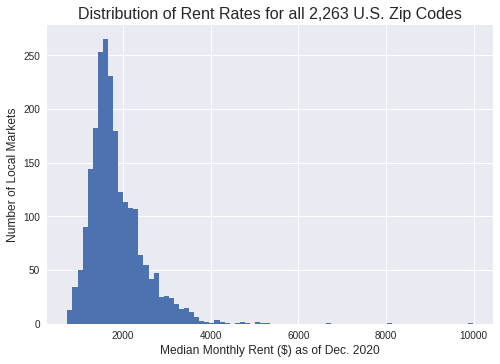

In [ ]:
plt.style.use('seaborn')
rents['2020-12'].hist(bins=80);
plt.title('Distribution of Rent Rates for all 2,263 U.S. Zip Codes', fontsize=16)
plt.xlabel('Median Monthly Rent ($) as of Dec. 2020', fontsize=12)
plt.ylabel('Number of Local Markets', fontsize=12);
# The quick plot below shows the vast majority of zip code markets have a rent value of < $2000/month.

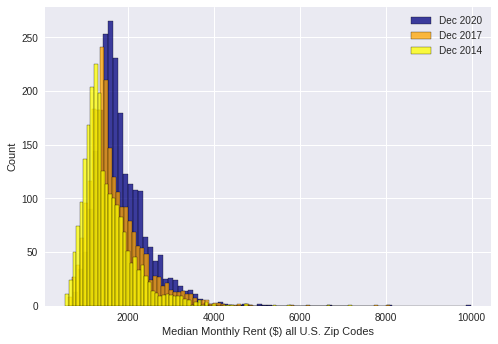

In [ ]:
# Let's look at an overlaid plot to see the difference over time, from end of the years 2014, 2017 and 2020
sns.histplot(rents['2020-12'], color = 'navy', label = 'Dec 2020', bins = 80)
sns.histplot(rents['2017-12'], color = 'orange', label = 'Dec 2017', bins = 80)
sns.histplot(rents['2014-12'], color = 'yellow', label = 'Dec 2014', bins = 80)
plt.xlabel('Median Monthly Rent ($) all U.S. Zip Codes')
plt.legend();

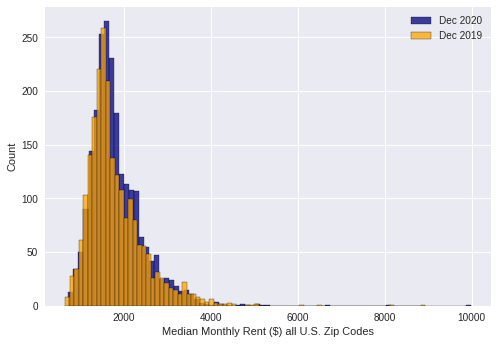

In [ ]:
# Let's look at an overlaid plot to see the difference in rents due to COVID, from end of the year 2019 and 2020
sns.histplot(rents['2020-12'], color = 'navy', label = 'Dec 2020', bins = 80)
sns.histplot(rents['2019-12'], color = 'orange', label = 'Dec 2019', bins = 80)
plt.xlabel('Median Monthly Rent ($) all U.S. Zip Codes')
plt.legend();

In [ ]:
# Interestingly enough, despite the impact of COVID-19, it appears more markets saw rent increases by the end of 2020.
# Let's evaluate the means
rents['2020-12'].mean()

1847.0994255413168

In [ ]:
rents['2019-12'].mean()

1816.0265134776846

So all major metro markets combined saw a 1.7% increase in the average (of all weighted medians) rent by end of 2020. The median market increased by 3.6% acrtually!  The trend we see in the histogram is confirmed by simply running the mean value for both 2019 & 2020. 

I am actually quite surprised to see overall rents increased during the year of 2020.  Possible explanations could be a larger portion of the rental market being larger size rental homes, as people moved and sought out larger spaces for their families due to the stay-at-home impact of COVID-19.

<Figure size 864x360 with 0 Axes>

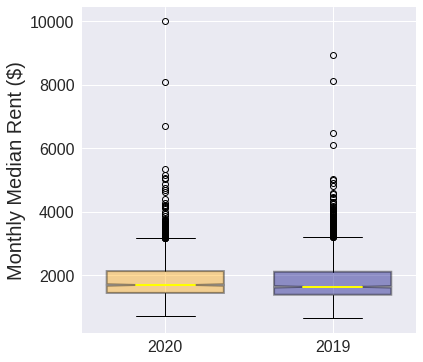

In [ ]:
# Let's look at a boxplot as well:
plt.figure(figsize = (12, 5))
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
boxplots = axes.boxplot([rents['2020-12'],rents['2019-12']],
           notch = True,
           labels=['2020', '2019'],
           widths = .7,
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
          );
# The more you understand any library, the more you can do
boxplot1 = boxplots['boxes'][0]
boxplot1.set_facecolor('orange')
boxplot2 = boxplots['boxes'][1]
boxplot2.set_facecolor('navy')
plt.ylabel('Monthly Median Rent ($)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16);

In [ ]:
max = rents['2020-12'].max()
max

9986.0

In [ ]:
min = rents['2020-12'].min()
min

727.0

In [ ]:
us_rent_mean = [(rents['2014-12'].mean()),
              (rents['2015-12'].mean()),
              (rents['2016-12'].mean()),
              (rents['2017-12'].mean()),
              (rents['2018-12'].mean()),
              (rents['2019-12'].mean()),
              (rents['2020-12'].mean())
            ]
us_rent_mean

[1512.0746796288113,
 1590.9933716305788,
 1648.4458683163941,
 1699.528501988511,
 1760.3703049049934,
 1816.0265134776846,
 1847.0994255413168]

In [ ]:
us_rent_median = [(rents['2014-12'].median()),
              (rents['2015-12'].median()),
              (rents['2016-12'].median()),
              (rents['2017-12'].median()),
              (rents['2018-12'].median()),
              (rents['2019-12'].median()),
              (rents['2020-12'].median())
            ]
us_rent_median

[1348.0, 1421.0, 1480.0, 1523.0, 1583.0, 1637.0, 1696.0]

In [ ]:
timeline = ['2014-12', '2015-12', '2016-12', '2017-12', '2018-12', '2019-12', '2020-12']

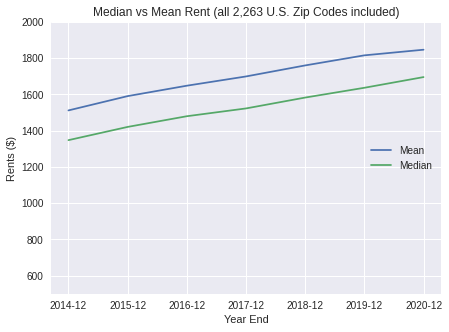

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize= (7,5))
plt.plot(timeline, us_rent_mean, label='Mean');
plt.plot(timeline, us_rent_median, label='Median')

plt.legend(loc='right')
plt.title('Median vs Mean Rent (all 2,263 U.S. Zip Codes included)')
plt.xlabel('Year End')
plt.ylabel('Rents ($)')
plt.ylim(500,2000);

In [ ]:
#We need to ensure our modeling isn't influenced by the metro market name, so we'll need to drop that column.
#We will create a new DF and drop the MSA Name since it is a string, in order to be able to use regression models.
rents_drop = rents.drop(columns=['MsaName'])

# Market Comparisons
The above visualizations were general, for the entire U.S.

Given the large data set size (2,263 zip codes), we're going to want to simplify our visualizations into only the top 3 markets (LA, NY, Miami) in terms of total zip codes. These 3 metro markets alone comprise just less than 20% of all zip codes in the dataset.

We'll also want to include the trendlines for all zip codes in the U.S. as well.

In [ ]:
USrents = rents.drop(columns='MsaName', axis=0)
USrents = USrents.transpose()
USrents

Zip Code,1752,1760,1801,1851,1852,1960,1970,2026,2108,2109,2110,2113,2114,2115,2116,2118,2119,2120,2121,2122,2124,2125,2127,2128,2130,2131,2132,2135,2138,2139,2141,2145,2148,2155,2169,2184,2210,2215,2301,2360,...,98118,98119,98121,98122,98133,98144,98155,98168,98198,98199,98201,98208,98258,98270,98271,98275,98327,98373,98374,98375,98387,98391,98402,98404,98405,98406,98409,98444,98445,98446,98466,98498,98607,98661,98662,98671,98682,98685,99205,99208
2014-01,1265.0,1752.0,1460.0,995.0,1065.0,1382.0,1413.0,1637.0,2392.0,2817.0,4037.0,2136.0,2415.0,2377.0,2500.0,2565.0,1568.0,3116.0,1744.0,1509.0,1672.0,1853.0,2282.0,1710.0,2052.0,1550.0,1673.0,1890.0,2133.0,2447.0,2391.0,2001.0,1721.0,1909.0,1501.0,2070.0,3108.0,1973.0,1326.0,1459.0,...,1086.0,1329.0,1912.0,1449.0,1165.0,1220.0,1422.0,1212.0,1145.0,1288.0,884.0,1095.0,1513.0,1487.0,1258.0,1334.0,1453.0,1139.0,1296.0,1426.0,1420.0,1205.0,980.0,940.0,944.0,985.0,961.0,865.0,1333.0,1149.0,1176.0,1009.0,1473.0,896.0,1089.0,1229.0,1064.0,1513.0,735.0,793.0
2014-02,1269.0,1750.0,1520.0,1005.0,1101.0,1410.0,1413.0,1637.0,2393.0,2817.0,4030.0,2148.0,2415.0,2382.0,2499.0,2571.0,1719.0,3124.0,1744.0,1518.0,1672.0,1853.0,2287.0,1723.0,2059.0,1565.0,1686.0,1897.0,2146.0,2448.0,2389.0,2005.0,1723.0,1914.0,1509.0,2073.0,3131.0,1978.0,1327.0,1459.0,...,1097.0,1329.0,1921.0,1458.0,1165.0,1325.0,1443.0,1212.0,1162.0,1318.0,897.0,1105.0,1525.0,1501.0,1258.0,1336.0,1459.0,1139.0,1309.0,1437.0,1428.0,1219.0,988.0,953.0,951.0,985.0,965.0,870.0,1343.0,1180.0,1176.0,1017.0,1519.0,906.0,1092.0,1229.0,1089.0,1513.0,732.0,806.0
2014-03,1272.0,1748.0,1520.0,1014.0,1101.0,1410.0,1413.0,1637.0,2394.0,2822.0,4023.0,2159.0,2415.0,2387.0,2498.0,2576.0,1719.0,3133.0,1783.0,1518.0,1672.0,1853.0,2293.0,1736.0,2066.0,1581.0,1699.0,1905.0,2160.0,2448.0,2387.0,2011.0,1724.0,1919.0,1518.0,2077.0,3179.0,1983.0,1328.0,1459.0,...,1109.0,1345.0,1930.0,1468.0,1176.0,1325.0,1464.0,1212.0,1162.0,1348.0,910.0,1114.0,1538.0,1515.0,1258.0,1339.0,1466.0,1148.0,1321.0,1448.0,1436.0,1233.0,996.0,953.0,959.0,994.0,969.0,881.0,1353.0,1180.0,1177.0,1033.0,1519.0,916.0,1096.0,1229.0,1089.0,1513.0,728.0,818.0
2014-04,1276.0,1746.0,1520.0,1024.0,1118.0,1410.0,1420.0,1669.0,2395.0,2827.0,4016.0,2170.0,2415.0,2392.0,2497.0,2581.0,1719.0,3142.0,1783.0,1518.0,1672.0,1853.0,2298.0,1749.0,2073.0,1596.0,1713.0,1912.0,2173.0,2448.0,2385.0,2011.0,1726.0,1924.0,1526.0,2081.0,3179.0,1989.0,1329.0,1459.0,...,1120.0,1376.0,1940.0,1478.0,1188.0,1325.0,1485.0,1212.0,1171.0,1379.0,923.0,1123.0,1550.0,1529.0,1266.0,1341.0,1473.0,1164.0,1334.0,1459.0,1444.0,1247.0,1004.0,960.0,966.0,1013.0,974.0,881.0,1363.0,1180.0,1178.0,1033.0,1519.0,927.0,1099.0,1229.0,1102.0,1524.0,725.0,868.0
2014-05,1280.0,1744.0,1539.0,1033.0,1135.0,1420.0,1428.0,1669.0,2396.0,2832.0,4006.0,2180.0,2415.0,2397.0,2496.0,2586.0,1766.0,3150.0,1783.0,1521.0,1672.0,1859.0,2304.0,1761.0,2079.0,1611.0,1725.0,1919.0,2186.0,2448.0,2383.0,2015.0,1727.0,1930.0,1534.0,2085.0,3199.0,1994.0,1330.0,1480.0,...,1132.0,1376.0,1949.0,1488.0,1199.0,1359.0,1504.0,1212.0,1179.0,1407.0,936.0,1133.0,1562.0,1542.0,1283.0,1344.0,1480.0,1164.0,1346.0,1470.0,1451.0,1260.0,1019.0,966.0,973.0,1013.0,978.0,886.0,1372.0,1199.0,1179.0,1042.0,1534.0,937.0,1103.0,1229.0,1114.0,1534.0,722.0,868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,1668.0,1962.0,2060.0,1442.0,1657.0,1887.0,1979.0,2062.0,2711.0,2899.0,4204.0,2341.0,2519.0,2601.0,2638.0,2876.0,2711.0,3658.0,2590.0,2302.0,2272.0,2439.0,2817.0,2313.0,2420.0,2201.0,2167.0,2195.0,2437.0,2660.0,2690.0,2539.0,2086.0,2332.0,1986.0,2455.0,3260.0,2265.0,1829.0,2061.0,...,1814.0,1804.0,2283.0,1847.0,1753.0,2039.0,2074.0,1764.0,1731.0,2157.0,1411.0,1641.0,2319.0,2285.0,1848.0,1761.0,20

In [ ]:
USrents = USrents.astype(float)
USrents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 2014-01 to 2020-12
Columns: 2263 entries, 1752 to 99208
dtypes: float64(2263)
memory usage: 1.5+ MB


In [ ]:
USmedians = (USrents.median(axis=1).values)
USmedians = np.array(USmedians)
USmedians = []

In [ ]:
#create DataFrames for each of the Top 3 markets
LosAngeles = rents.loc[(rents['MsaName'] == 'Los Angeles-Long Beach-Anaheim, CA')]
LosAngeles.shape

(165, 85)

In [ ]:
LosAngeles = LosAngeles.drop(columns='MsaName', axis=1)
LosAngeles.head(2)

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
Zip Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90004,1655.0,1692.0,1692.0,1692.0,1705.0,1718.0,1731.0,1745.0,1758.0,1771.0,1787.0,1802.0,1818.0,1833.0,1848.0,1864.0,1873.0,1882.0,1892.0,1900.0,1907.0,1915.0,1925.0,1935.0,1944.0,1953.0,1962.0,1971.0,1981.0,1992.0,2003.0,2016.0,2029.0,2042.0,2056.0,2069.0,2083.0,2096.0,2109.0,2122.0,...,2167.0,2173.0,2178.0,2182.0,2186.0,2191.0,2197.0,2202.0,2208.0,2213.0,2219.0,2225.0,2230.0,2236.0,2242.0,2248.0,2255.0,2259.0,2264.0,2269.0,2271.0,2273.0,2275.0,2276.0,2277.0,2278.0,2276.0,2275.0,2273.0,2269.0,2265.0,2262.0,2257.0,2252.0,2247.0,2243.0,2238.0,2233.0,2228.0,2223.0
90006,1050.0,1050.0,1056.0,1062.0,1069.0,1075.0,1123.0,1123.0,1123.0,1123.0,1123.0,1123.0,1123.0,1141.0,1141.0,1151.0,1159.0,1168.0,1177.0,1187.0,1196.0,1206.0,1216.0,1226.0,1237.0,1248.0,1259.0,1270.0,1285.0,1300.0,1315.0,1331.0,1347.0,1363.0,1378.0,1392.0,1407.0,1419.0,1430.0,1442.0,...,1465.0,1468.0,1472.0,1477.0,1481.0,1486.0,1491.0,1495.0,1501.0,1506.0,1512.0,1517.0,1522.0,1527.0,1532.0,1537.0,1541.0,1546.0,1550.0,1554.0,1559.0,1564.0,1568.0,1572.0,1575.0,1578.0,1579.0,1579.0,1580.0,1579.0,1578.0,1576.0,1575.0,1573.0,1572.0,1570.0,1568.0,1567.0,1565.0,1563.0


In [ ]:
LosAngeles = LosAngeles.transpose()
LosAngeles.head(2)

Zip Code,90004,90006,90007,90012,90013,90015,90016,90017,90018,90020,90024,90025,90026,90027,90029,90034,90035,90036,90038,90039,90042,90045,90048,90064,90066,90068,90069,90094,90211,90212,90230,90232,90242,90245,90250,90254,90265,90266,90274,90275,...,92614,92618,92620,92626,92627,92630,92637,92646,92647,92648,92649,92651,92653,92656,92660,92663,92672,92677,92688,92691,92692,92694,92704,92708,92782,92805,92806,92807,92808,92821,92831,92832,92833,92840,92865,92868,92870,92886,92887,93536
2014-01,1655.0,1050.0,1115.0,2017.0,2084.0,2237.0,1621.0,2066.0,1225.0,1358.0,2432.0,2034.0,1703.0,1544.0,1307.0,1709.0,2167.0,2145.0,1616.0,1947.0,1557.0,1748.0,2236.0,2380.0,1670.0,2064.0,2252.0,3001.0,2247.0,2857.0,1643.0,2284.0,1297.0,1992.0,1211.0,2474.0,5739.0,3526.0,3582.0,3222.0,...,1955.0,2689.0,2863.0,1717.0,1947.0,2218.0,1555.0,2194.0,1560.0,1910.0,1847.0,3340.0,1711.0,2036.0,3493.0,2542.0,1970.0,2278.0,1897.0,2163.0,2205.0,2510.0,1664.0,2270.0,2218.0,1395.0,1628.0,1810.0,2034.0,1763.0,1834.0,1802.0,1982.0,1734.0,2221.0,1862.0,2008.0,2501.0,2781.0,1419.0
2014-02,1692.0,1050.0,1123.0,2017.0,2084.0,2237.0,1621.0,2088.0,1279.0,1358.0,2432.0,2053.0,1717.0,1544.0,1307.0,1720.0,2167.0,2145.0,1616.0,1947.0,1567.0,1903.0,2270.0,2380.0,1688.0,2185.0,2389.0,3028.0,2390.0,2802.0,1853.0,2308.0,1297.0,1992.0,1220.0,2497.0,5826.0,3550.0,3582.0,3236.0,...,2003.0,2710.0,2863.0,1717.0,1954.0,2230.0,1563.0,2204.0,1580.0,1928.0,1857.0,3390.0,1745.0,2047.0,3508.0,2575.0,1982.0,2290.0,1904.0,2178.0,2205.0,2516.0,1682.0,2388.0,2224.0,1411.0,1628.0,1827.0,2061.0,1765.0,1847.0,1793.0,1988.0,1734.0,2221.0,1862.0,2024.0,2504.0,2785.0,1430.0


In [ ]:
LosAngeles = LosAngeles.astype(float)
LosAngeles.head()

Zip Code,90004,90006,90007,90012,90013,90015,90016,90017,90018,90020,90024,90025,90026,90027,90029,90034,90035,90036,90038,90039,90042,90045,90048,90064,90066,90068,90069,90094,90211,90212,90230,90232,90242,90245,90250,90254,90265,90266,90274,90275,...,92614,92618,92620,92626,92627,92630,92637,92646,92647,92648,92649,92651,92653,92656,92660,92663,92672,92677,92688,92691,92692,92694,92704,92708,92782,92805,92806,92807,92808,92821,92831,92832,92833,92840,92865,92868,92870,92886,92887,93536
2014-01,1655.0,1050.0,1115.0,2017.0,2084.0,2237.0,1621.0,2066.0,1225.0,1358.0,2432.0,2034.0,1703.0,1544.0,1307.0,1709.0,2167.0,2145.0,1616.0,1947.0,1557.0,1748.0,2236.0,2380.0,1670.0,2064.0,2252.0,3001.0,2247.0,2857.0,1643.0,2284.0,1297.0,1992.0,1211.0,2474.0,5739.0,3526.0,3582.0,3222.0,...,1955.0,2689.0,2863.0,1717.0,1947.0,2218.0,1555.0,2194.0,1560.0,1910.0,1847.0,3340.0,1711.0,2036.0,3493.0,2542.0,1970.0,2278.0,1897.0,2163.0,2205.0,2510.0,1664.0,2270.0,2218.0,1395.0,1628.0,1810.0,2034.0,1763.0,1834.0,1802.0,1982.0,1734.0,2221.0,1862.0,2008.0,2501.0,2781.0,1419.0
2014-02,1692.0,1050.0,1123.0,2017.0,2084.0,2237.0,1621.0,2088.0,1279.0,1358.0,2432.0,2053.0,1717.0,1544.0,1307.0,1720.0,2167.0,2145.0,1616.0,1947.0,1567.0,1903.0,2270.0,2380.0,1688.0,2185.0,2389.0,3028.0,2390.0,2802.0,1853.0,2308.0,1297.0,1992.0,1220.0,2497.0,5826.0,3550.0,3582.0,3236.0,...,2003.0,2710.0,2863.0,1717.0,1954.0,2230.0,1563.0,2204.0,1580.0,1928.0,1857.0,3390.0,1745.0,2047.0,3508.0,2575.0,1982.0,2290.0,1904.0,2178.0,2205.0,2516.0,1682.0,2388.0,2224.0,1411.0,1628.0,1827.0,2061.0,1765.0,1847.0,1793.0,1988.0,1734.0,2221.0,1862.0,2024.0,2504.0,2785.0,1430.0
2014-03,1692.0,1056.0,1139.0,2017.0,2080.0,2238.0,1626.0,2111.0,1279.0,1358.0,2431.0,2072.0,1731.0,1574.0,1319.0,1731.0,2181.0,2160.0,1634.0,1980.0,1588.0,1903.0,2304.0,2463.0,1707.0,2185.0,2389.0,3028.0,2390.0,2802.0,1853.0,2308.0,1297.0,1992.0,1229.0,2542.0,5913.0,3599.0,3604.0,3250.0,...,2003.0,2710.0,2881.0,1717.0,1961.0,2241.0,1570.0,2215.0,1599.0,1945.0,1868.0,3440.0,1814.0,2057.0,3522.0,2607.0,1994.0,2303.0,1910.0,2193.0,2218.0,2521.0,1718.0,2388.0,2231.0,1426.0,1626.0,1879.0,2089.0,1768.0,1860.0,1776.0,2001.0,1734.0,2221.0,1862.0,2057.0,2508.0,2789.0,1440.0
2014-04,1692.0,1062.0,1139.0,2017.0,2076.0,2240.0,1631.0,2221.0,1306.0,1358.0,2430.0,2090.0,1745.0,1603.0,1331.0,1742.0,2194.0,2174.0,1652.0,2044.0,1588.0,1903.0,2338.0,2463.0,1725.0,2185.0,2389.0,3055.0,2390.0,2802.0,1853.0,2344.0,1297.0,1996.0,1239.0,2542.0,6000.0,3599.0,3626.0,3264.0,...,2003.0,2721.0,2899.0,1729.0,1967.0,2252.0,1578.0,2225.0,1619.0,1963.0,1878.0,3490.0,1814.0,2068.0,3537.0,2639.0,2007.0,2315.0,1916.0,2209.0,2230.0,2527.0,1718.0,2388.0,2237.0,1442.0,1624.0,1879.0,2116.0,1770.0,1873.0,1776.0,2001.0,1734.0,2243.0,1867.0,2057.0,2512.0,2792.0,1451.0
2014-05,1705.0,1069.0,1195.0,2043.0,2066.0,2242.0,1637.0,2221.0,1403.0,1358.0,2431.0,2108.0,1759.0,1631.0,1342.0,1753.0,2208.0,2189.0,1670.0,2044.0,1598.0,1952.0,2371.0,2504.0,1743.0,2223.0,2433.0,3055.0,2438.0,2802.0,1853.0,2344.0,1297.0,1996.0,1248.0,2563.0,6084.0,3625.0,3647.0,3279.0,...,2019.0,2731.0,2917.0,1741.0,1974.0,2264.0,1585.0,2237.0,1639.0,1979.0,1888.0,3537.0,1847.0,2078.0,3552.0,2672.0,2019.0,2327.0,1923.0,2223.0,2242.0,2532.0,1734.0,2388.0,2244.0,1456.0,1622.0,1879.0,2143.0,1773.0,1885.0,1769.0,2008.0,1747.0,2285.0,1878.0,2073.0,2516.0,2801.0,1461.0


In [ ]:
LAmedians = (LosAngeles.median(axis=1).values)
LAmedians = np.array(LAmedians)
LAmedians

array([1834., 1857., 1877., 1878., 1888., 1898., 1919., 1942., 1960.,
       1984., 1999., 2009., 2020., 2026., 2034., 2042., 2044., 2058.,
       2076., 2091., 2106., 2121., 2132., 2143., 2154., 2164., 2173.,
       2183., 2190., 2192., 2194., 2195., 2197., 2209., 2220., 2232.,
       2243., 2255., 2266., 2278., 2290., 2302., 2307., 2311., 2318.,
       2329., 2338., 2347., 2355., 2362., 2367., 2375., 2381., 2388.,
       2395., 2404., 2410., 2419., 2427., 2435., 2443., 2450., 2457.,
       2459., 2464., 2471., 2478., 2487., 2493., 2498., 2504., 2509.,
       2513., 2517., 2518., 2519., 2522., 2526., 2529., 2532., 2534.,
       2536., 2536., 2532.])

In [ ]:
NewYork = rents.loc[(rents['MsaName'] =='New York, NY')]
NewYork.shape

(133, 85)

In [ ]:
NewYork = NewYork.drop(columns='MsaName', axis=1)
NewYork.head(2)

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
Zip Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7002,1333.0,1337.0,1342.0,1346.0,1351.0,1355.0,1360.0,1364.0,1369.0,1374.0,1381.0,1389.0,1396.0,1403.0,1411.0,1419.0,1427.0,1435.0,1442.0,1451.0,1459.0,1467.0,1471.0,1475.0,1479.0,1481.0,1483.0,1486.0,1490.0,1495.0,1500.0,1505.0,1510.0,1515.0,1521.0,1528.0,1534.0,1541.0,1548.0,1555.0,...,1577.0,1582.0,1589.0,1595.0,1602.0,1610.0,1619.0,1627.0,1636.0,1645.0,1655.0,1663.0,1672.0,1681.0,1689.0,1698.0,1706.0,1711.0,1717.0,1722.0,1725.0,1728.0,1731.0,1732.0,1733.0,1735.0,1734.0,1733.0,1732.0,1735.0,1738.0,1740.0,1745.0,1749.0,1754.0,1758.0,1763.0,1768.0,1773.0,1779.0
7013,1489.0,1564.0,1564.0,1564.0,1588.0,1612.0,1636.0,1659.0,1682.0,1705.0,1720.0,1735.0,1756.0,1756.0,1767.0,1767.0,1768.0,1769.0,1769.0,1768.0,1767.0,1766.0,1769.0,1772.0,1775.0,1782.0,1788.0,1794.0,1805.0,1815.0,1825.0,1835.0,1845.0,1855.0,1860.0,1865.0,1870.0,1876.0,1876.0,1879.0,...,1893.0,1898.0,1904.0,1911.0,1918.0,1925.0,1932.0,1939.0,1946.0,1952.0,1959.0,1962.0,1965.0,1968.0,1973.0,1978.0,1984.0,1987.0,1990.0,1994.0,1989.0,1985.0,1981.0,1979.0,1977.0,1975.0,1975.0,1976.0,1977.0,1979.0,1982.0,1984.0,1989.0,1993.0,1998.0,2003.0,2009.0,2014.0,2019.0,2025.0


In [ ]:
NewYork = NewYork.transpose()
NewYork.head(2)

Zip Code,7002,7013,7016,7024,7030,7042,7047,7083,7086,7087,7093,7104,7302,7304,7305,7307,7410,7446,7470,7631,7701,7726,7732,7740,7920,7921,7928,7950,7960,8527,8536,8742,8816,8817,8844,8852,8854,8876,8901,8902,...,11021,11050,11104,11109,11201,11205,11206,11207,11209,11210,11211,11212,11213,11215,11216,11217,11218,11221,11223,11226,11228,11231,11236,11237,11238,11249,11357,11358,11360,11361,11375,11377,11415,11435,11501,11542,11735,11743,11746,12601
2014-01,1333.0,1489.0,1750.0,1749.0,2387.0,1596.0,1525.0,1610.0,1927.0,1584.0,1524.0,962.0,2321.0,1208.0,1367.0,1388.0,1863.0,1704.0,2323.0,1839.0,1617.0,1564.0,1330.0,1333.0,2206.0,1736.0,2106.0,2229.0,2130.0,1632.0,1362.0,1743.0,1742.0,1365.0,1481.0,1725.0,1721.0,2006.0,1432.0,1699.0,...,2930.0,2323.0,1750.0,2892.0,2948.0,2402.0,2415.0,1785.0,1569.0,1644.0,2795.0,1637.0,1723.0,2597.0,2081.0,2551.0,1964.0,2039.0,1395.0,1631.0,1711.0,2796.0,1451.0,2218.0,2343.0,3245.0,1737.0,1649.0,2121.0,1834.0,1676.0,1815.0,1630.0,1415.0,2383.0,2231.0,1786.0,2122.0,1939.0,1002.0
2014-02,1337.0,1564.0,1761.0,1779.0,2405.0,1596.0,1530.0,1682.0,1950.0,1592.0,1533.0,962.0,2336.0,1208.0,1375.0,1391.0,1863.0,1761.0,2323.0,1862.0,1621.0,1568.0,1336.0,1386.0,2216.0,1736.0,2107.0,2232.0,2127.0,1632.0,1374.0,1816.0,1752.0,1399.0,1563.0,1725.0,1732.0,2006.0,1432.0,1692.0,...,2937.0,2394.0,1757.0,2910.0,2964.0,2415.0,2425.0,1796.0,1578.0,1669.0,2813.0,1642.0,1741.0,2602.0,2092.0,2571.0,1972.0,2053.0,1400.0,1636.0,1711.0,2797.0,1461.0,2231.0,2360.0,3256.0,1737.0,1655.0,2124.0,1848.0,1685.0,1817.0,1635.0,1426.0,2377.0,2241.0,1790.0,2124.0,1935.0,1004.0


In [ ]:
NewYork = NewYork.astype(float)
NewYork.head()

Zip Code,7002,7013,7016,7024,7030,7042,7047,7083,7086,7087,7093,7104,7302,7304,7305,7307,7410,7446,7470,7631,7701,7726,7732,7740,7920,7921,7928,7950,7960,8527,8536,8742,8816,8817,8844,8852,8854,8876,8901,8902,...,11021,11050,11104,11109,11201,11205,11206,11207,11209,11210,11211,11212,11213,11215,11216,11217,11218,11221,11223,11226,11228,11231,11236,11237,11238,11249,11357,11358,11360,11361,11375,11377,11415,11435,11501,11542,11735,11743,11746,12601
2014-01,1333.0,1489.0,1750.0,1749.0,2387.0,1596.0,1525.0,1610.0,1927.0,1584.0,1524.0,962.0,2321.0,1208.0,1367.0,1388.0,1863.0,1704.0,2323.0,1839.0,1617.0,1564.0,1330.0,1333.0,2206.0,1736.0,2106.0,2229.0,2130.0,1632.0,1362.0,1743.0,1742.0,1365.0,1481.0,1725.0,1721.0,2006.0,1432.0,1699.0,...,2930.0,2323.0,1750.0,2892.0,2948.0,2402.0,2415.0,1785.0,1569.0,1644.0,2795.0,1637.0,1723.0,2597.0,2081.0,2551.0,1964.0,2039.0,1395.0,1631.0,1711.0,2796.0,1451.0,2218.0,2343.0,3245.0,1737.0,1649.0,2121.0,1834.0,1676.0,1815.0,1630.0,1415.0,2383.0,2231.0,1786.0,2122.0,1939.0,1002.0
2014-02,1337.0,1564.0,1761.0,1779.0,2405.0,1596.0,1530.0,1682.0,1950.0,1592.0,1533.0,962.0,2336.0,1208.0,1375.0,1391.0,1863.0,1761.0,2323.0,1862.0,1621.0,1568.0,1336.0,1386.0,2216.0,1736.0,2107.0,2232.0,2127.0,1632.0,1374.0,1816.0,1752.0,1399.0,1563.0,1725.0,1732.0,2006.0,1432.0,1692.0,...,2937.0,2394.0,1757.0,2910.0,2964.0,2415.0,2425.0,1796.0,1578.0,1669.0,2813.0,1642.0,1741.0,2602.0,2092.0,2571.0,1972.0,2053.0,1400.0,1636.0,1711.0,2797.0,1461.0,2231.0,2360.0,3256.0,1737.0,1655.0,2124.0,1848.0,1685.0,1817.0,1635.0,1426.0,2377.0,2241.0,1790.0,2124.0,1935.0,1004.0
2014-03,1342.0,1564.0,1773.0,1810.0,2423.0,1600.0,1536.0,1682.0,1997.0,1599.0,1542.0,954.0,2351.0,1228.0,1383.0,1394.0,1863.0,1761.0,2333.0,1862.0,1625.0,1571.0,1343.0,1386.0,2226.0,1753.0,2108.0,2236.0,2125.0,1632.0,1374.0,1816.0,1762.0,1399.0,1563.0,1725.0,1743.0,2006.0,1432.0,1692.0,...,2943.0,2394.0,1764.0,2928.0,2980.0,2427.0,2435.0,1806.0,1588.0,1669.0,2831.0,1647.0,1758.0,2607.0,2102.0,2592.0,1981.0,2066.0,1406.0,1640.0,1711.0,2798.0,1470.0,2243.0,2377.0,3266.0,1740.0,1665.0,2124.0,1877.0,1695.0,1819.0,1641.0,1436.0,2371.0,2251.0,1795.0,2126.0,1930.0,1006.0
2014-04,1346.0,1564.0,1784.0,1840.0,2440.0,1600.0,1541.0,1682.0,1997.0,1607.0,1551.0,954.0,2366.0,1228.0,1390.0,1396.0,1863.0,1761.0,2333.0,1907.0,1628.0,1574.0,1349.0,1386.0,2236.0,1771.0,2109.0,2239.0,2122.0,1632.0,1381.0,1816.0,1772.0,1415.0,1563.0,1725.0,1754.0,2006.0,1432.0,1689.0,...,2950.0,2394.0,1771.0,2946.0,2996.0,2439.0,2446.0,1817.0,1597.0,1682.0,2849.0,1653.0,1775.0,2611.0,2112.0,2612.0,1990.0,2080.0,1411.0,1644.0,1711.0,2800.0,1480.0,2256.0,2394.0,3277.0,1743.0,1665.0,2124.0,1877.0,1704.0,1821.0,1647.0,1447.0,2365.0,2261.0,1805.0,2129.0,1926.0,1008.0
2014-05,1351.0,1588.0,1795.0,1868.0,2457.0,1603.0,1548.0,1750.0,2020.0,1614.0,1560.0,943.0,2380.0,1237.0,1398.0,1400.0,1863.0,1761.0,2338.0,1907.0,1632.0,1577.0,1356.0,1457.0,2246.0,1789.0,2110.0,2242.0,2119.0,1632.0,1386.0,1816.0,1781.0,1432.0,1588.0,1725.0,1764.0,2006.0,1432.0,1686.0,...,2957.0,2418.0,1778.0,2965.0,3011.0,2452.0,2456.0,1827.0,1606.0,1696.0,2866.0,1658.0,1793.0,2616.0,2122.0,2631.0,1998.0,2093.0,1417.0,1649.0,1711.0,2802.0,1488.0,2268.0,2410.0,3287.0,1747.0,1671.0,2125.0,1891.0,1714.0,1824.0,1653.0,1457.0,2360.0,2270.0,1805.0,2131.0,1923.0,1011.0


In [ ]:
NYmedians = (NewYork.median(axis=1).values)
NYmedians = np.array(NYmedians)
NYmedians

array([1991., 2006., 2006., 2007., 2020., 2043., 2063., 2071., 2079.,
       2095., 2110., 2112., 2113., 2120., 2127., 2134., 2139., 2133.,
       2133., 2133., 2144., 2155., 2188., 2188., 2188., 2188., 2197.,
       2206., 2216., 2228., 2233., 2243., 2251., 2250., 2250., 2250.,
       2250., 2255., 2260., 2265., 2273., 2281., 2284., 2285., 2285.,
       2293., 2294., 2296., 2297., 2302., 2306., 2308., 2311., 2315.,
       2319., 2323., 2324., 2325., 2328., 2331., 2334., 2340., 2349.,
       2358., 2361., 2363., 2366., 2367., 2368., 2369., 2370., 2371.,
       2375., 2379., 2374., 2367., 2362., 2354., 2358., 2351., 2344.,
       2338., 2331., 2324.])

In [ ]:
Miami = rents.loc[(rents['MsaName'] == 'Miami-Fort Lauderdale, FL')]
Miami.shape

(122, 85)

In [ ]:
Miami = Miami.drop(columns='MsaName', axis=1)
Miami.head(2)

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
Zip Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33009,1425.0,1438.0,1452.0,1466.0,1479.0,1492.0,1506.0,1519.0,1532.0,1545.0,1555.0,1564.0,1574.0,1580.0,1586.0,1592.0,1598.0,1603.0,1608.0,1612.0,1617.0,1621.0,1626.0,1631.0,1635.0,1639.0,1642.0,1645.0,1646.0,1646.0,1647.0,1646.0,1646.0,1645.0,1646.0,1647.0,1648.0,1650.0,1653.0,1655.0,...,1668.0,1670.0,1672.0,1673.0,1675.0,1677.0,1678.0,1680.0,1682.0,1683.0,1685.0,1687.0,1689.0,1691.0,1692.0,1694.0,1696.0,1697.0,1698.0,1699.0,1701.0,1703.0,1705.0,1707.0,1709.0,1711.0,1711.0,1711.0,1711.0,1709.0,1708.0,1706.0,1703.0,1701.0,1698.0,1696.0,1693.0,1690.0,1687.0,1684.0
33012,1189.0,1192.0,1195.0,1198.0,1201.0,1204.0,1207.0,1209.0,1212.0,1215.0,1220.0,1224.0,1229.0,1235.0,1240.0,1246.0,1262.0,1262.0,1262.0,1269.0,1276.0,1283.0,1290.0,1298.0,1305.0,1311.0,1316.0,1322.0,1326.0,1331.0,1335.0,1340.0,1344.0,1349.0,1352.0,1356.0,1359.0,1362.0,1364.0,1367.0,...,1374.0,1375.0,1377.0,1379.0,1380.0,1380.0,1380.0,1380.0,1378.0,1377.0,1376.0,1375.0,1375.0,1374.0,1376.0,1377.0,1378.0,1383.0,1387.0,1391.0,1396.0,1401.0,1406.0,1407.0,1408.0,1409.0,1408.0,1406.0,1405.0,1406.0,1408.0,1409.0,1412.0,1414.0,1416.0,1419.0,1422.0,1425.0,1428.0,1431.0


In [ ]:
Miami = Miami.transpose()
Miami.head(2)

Zip Code,33009,33012,33014,33015,33016,33018,33019,33020,33023,33024,33025,33026,33027,33028,33030,33033,33060,33062,33063,33064,33065,33067,33068,33069,33071,33073,33076,33125,33126,33129,33130,33131,33132,33133,33134,33136,33138,33139,33140,33141,...,33324,33325,33326,33328,33334,33351,33401,33404,33406,33407,33408,33409,33410,33411,33414,33415,33417,33418,33426,33428,33431,33432,33433,33435,33436,33437,33442,33444,33445,33458,33460,33461,33462,33463,33467,33469,33477,33486,33487,33496
2014-01,1425.0,1189.0,1212.0,1228.0,1316.0,1990.0,1869.0,1191.0,1417.0,1389.0,1412.0,1411.0,1666.0,2110.0,1145.0,1206.0,1123.0,1668.0,1129.0,1268.0,1142.0,1588.0,1321.0,1158.0,1209.0,1779.0,2479.0,1277.0,1246.0,1912.0,2035.0,2246.0,2078.0,1710.0,1745.0,1359.0,1238.0,1743.0,2198.0,1486.0,...,1342.0,1363.0,1599.0,1482.0,1155.0,1281.0,1481.0,1843.0,1177.0,1134.0,1792.0,1059.0,1472.0,1272.0,2175.0,1054.0,963.0,2001.0,1273.0,1715.0,1756.0,1389.0,1654.0,1355.0,1227.0,2094.0,1426.0,1657.0,1334.0,1707.0,960.0,1167.0,1224.0,1259.0,1673.0,1708.0,2929.0,1815.0,2061.0,1789.0
2014-02,1438.0,1192.0,1222.0,1232.0,1322.0,1988.0,1882.0,1198.0,1423.0,1398.0,1417.0,1420.0,1671.0,2123.0,1155.0,1214.0,1129.0,1679.0,1135.0,1273.0,1148.0,1591.0,1325.0,1160.0,1214.0,1786.0,2486.0,1307.0,1252.0,1929.0,2040.0,2254.0,2085.0,1721.0,1757.0,1365.0,1246.0,1752.0,2213.0,1494.0,...,1346.0,1372.0,1607.0,1486.0,1159.0,1268.0,1488.0,1859.0,1185.0,1142.0,1802.0,1063.0,1480.0,1277.0,2187.0,1055.0,969.0,2018.0,1277.0,1726.0,1771.0,1414.0,1665.0,1358.0,1234.0,2106.0,1435.0,1662.0,1342.0,1718.0,963.0,1169.0,1232.0,1263.0,1677.0,1721.0,3015.0,1837.0,2082.0,1814.0


In [ ]:
Miami = Miami.astype(float)
Miami.head()

Zip Code,33009,33012,33014,33015,33016,33018,33019,33020,33023,33024,33025,33026,33027,33028,33030,33033,33060,33062,33063,33064,33065,33067,33068,33069,33071,33073,33076,33125,33126,33129,33130,33131,33132,33133,33134,33136,33138,33139,33140,33141,...,33324,33325,33326,33328,33334,33351,33401,33404,33406,33407,33408,33409,33410,33411,33414,33415,33417,33418,33426,33428,33431,33432,33433,33435,33436,33437,33442,33444,33445,33458,33460,33461,33462,33463,33467,33469,33477,33486,33487,33496
2014-01,1425.0,1189.0,1212.0,1228.0,1316.0,1990.0,1869.0,1191.0,1417.0,1389.0,1412.0,1411.0,1666.0,2110.0,1145.0,1206.0,1123.0,1668.0,1129.0,1268.0,1142.0,1588.0,1321.0,1158.0,1209.0,1779.0,2479.0,1277.0,1246.0,1912.0,2035.0,2246.0,2078.0,1710.0,1745.0,1359.0,1238.0,1743.0,2198.0,1486.0,...,1342.0,1363.0,1599.0,1482.0,1155.0,1281.0,1481.0,1843.0,1177.0,1134.0,1792.0,1059.0,1472.0,1272.0,2175.0,1054.0,963.0,2001.0,1273.0,1715.0,1756.0,1389.0,1654.0,1355.0,1227.0,2094.0,1426.0,1657.0,1334.0,1707.0,960.0,1167.0,1224.0,1259.0,1673.0,1708.0,2929.0,1815.0,2061.0,1789.0
2014-02,1438.0,1192.0,1222.0,1232.0,1322.0,1988.0,1882.0,1198.0,1423.0,1398.0,1417.0,1420.0,1671.0,2123.0,1155.0,1214.0,1129.0,1679.0,1135.0,1273.0,1148.0,1591.0,1325.0,1160.0,1214.0,1786.0,2486.0,1307.0,1252.0,1929.0,2040.0,2254.0,2085.0,1721.0,1757.0,1365.0,1246.0,1752.0,2213.0,1494.0,...,1346.0,1372.0,1607.0,1486.0,1159.0,1268.0,1488.0,1859.0,1185.0,1142.0,1802.0,1063.0,1480.0,1277.0,2187.0,1055.0,969.0,2018.0,1277.0,1726.0,1771.0,1414.0,1665.0,1358.0,1234.0,2106.0,1435.0,1662.0,1342.0,1718.0,963.0,1169.0,1232.0,1263.0,1677.0,1721.0,3015.0,1837.0,2082.0,1814.0
2014-03,1452.0,1195.0,1232.0,1237.0,1335.0,1983.0,1894.0,1205.0,1429.0,1406.0,1422.0,1429.0,1677.0,2135.0,1164.0,1221.0,1135.0,1690.0,1141.0,1278.0,1153.0,1594.0,1328.0,1164.0,1219.0,1793.0,2494.0,1307.0,1258.0,1945.0,2045.0,2262.0,2092.0,1733.0,1769.0,1376.0,1254.0,1761.0,2228.0,1502.0,...,1351.0,1382.0,1615.0,1491.0,1164.0,1268.0,1495.0,1876.0,1193.0,1149.0,1811.0,1068.0,1487.0,1282.0,2211.0,1055.0,975.0,2035.0,1281.0,1736.0,1785.0,1466.0,1676.0,1362.0,1240.0,2128.0,1445.0,1668.0,1350.0,1730.0,971.0,1173.0,1241.0,1267.0,1680.0,1746.0,3015.0,1837.0,2104.0,1839.0
2014-04,1466.0,1198.0,1278.0,1242.0,1335.0,1983.0,1907.0,1211.0,1435.0,1415.0,1427.0,1439.0,1682.0,2148.0,1174.0,1228.0,1141.0,1702.0,1147.0,1284.0,1158.0,1597.0,1332.0,1164.0,1224.0,1800.0,2502.0,1322.0,1264.0,1961.0,2050.0,2270.0,2099.0,1744.0,1781.0,1376.0,1263.0,1771.0,2243.0,1510.0,...,1356.0,1392.0,1623.0,1495.0,1168.0,1268.0,1502.0,1892.0,1201.0,1157.0,1820.0,1072.0,1494.0,1287.0,2211.0,1055.0,980.0,2052.0,1286.0,1747.0,1799.0,1466.0,1686.0,1365.0,1247.0,2128.0,1454.0,1674.0,1359.0,1741.0,971.0,1173.0,1250.0,1271.0,1684.0,1746.0,3015.0,1847.0,2126.0,1864.0
2014-05,1479.0,1201.0,1278.0,1247.0,1341.0,1979.0,1919.0,1218.0,1441.0,1424.0,1432.0,1448.0,1688.0,2160.0,1193.0,1236.0,1148.0,1713.0,1153.0,1289.0,1164.0,1600.0,1336.0,1166.0,1229.0,1807.0,2509.0,1337.0,1271.0,1976.0,2055.0,2279.0,2107.0,1756.0,1792.0,1382.0,1271.0,1780.0,2257.0,1519.0,...,1361.0,1402.0,1631.0,1500.0,1172.0,1265.0,1509.0,1909.0,1208.0,1164.0,1829.0,1076.0,1502.0,1292.0,2222.0,1056.0,986.0,2068.0,1290.0,1757.0,1814.0,1490.0,1697.0,1368.0,1253.0,2139.0,1463.0,1680.0,1367.0,1752.0,975.0,1175.0,1258.0,1276.0,1687.0,1759.0,3015.0,1858.0,2146.0,1887.0


In [ ]:
Miamimedians = (Miami.median(axis=1).values)
Miamimedians

array([1425.5, 1436. , 1448.5, 1460. , 1471. , 1482.5, 1492.5, 1501. ,
       1508.5, 1515. , 1520. , 1525. , 1530. , 1534.5, 1539. , 1543.5,
       1549. , 1554.5, 1560. , 1566.5, 1572.5, 1578.5, 1586.5, 1595. ,
       1603. , 1609.5, 1616.5, 1622.5, 1627.5, 1629.5, 1632. , 1633. ,
       1634.5, 1636. , 1638.5, 1640.5, 1643. , 1646. , 1649.5, 1653. ,
       1656.5, 1660. , 1664. , 1668.5, 1672.5, 1677. , 1680. , 1684. ,
       1688. , 1693.5, 1698.5, 1703.5, 1708.5, 1713.5, 1718.5, 1723.5,
       1728. , 1732.5, 1736.5, 1740.5, 1744.5, 1748.5, 1753. , 1758. ,
       1762.5, 1768. , 1771. , 1774.5, 1777. , 1779. , 1779.5, 1780.5,
       1785.5, 1791.5, 1796.5, 1801. , 1801. , 1801. , 1806. , 1817. ,
       1827.5, 1835. , 1836.5, 1841. ])

In [ ]:
monthly_timeline = ('2014-01', '2014-02',	'2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12',
                    '2015-01', '2015-02',	'2015-03','2015-04','2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12',
                    '2016-01', '2016-02',	'2016-03','2016-04','2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12',
                    '2017-01', '2017-02',	'2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12',
                    '2018-01', '2018-02',	'2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12',
                    '2019-01', '2019-02',	'2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12',
                    '2020-01', '2020-02',	'2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12')
monthly_array = np.array(monthly_timeline)
monthly_array

array(['2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', 

## Now that we've finally filtered through the data to isolate the medians of all 3 major markets, and also the U.S. as a whole, let's plot the trends to compare!

ValueError: ignored

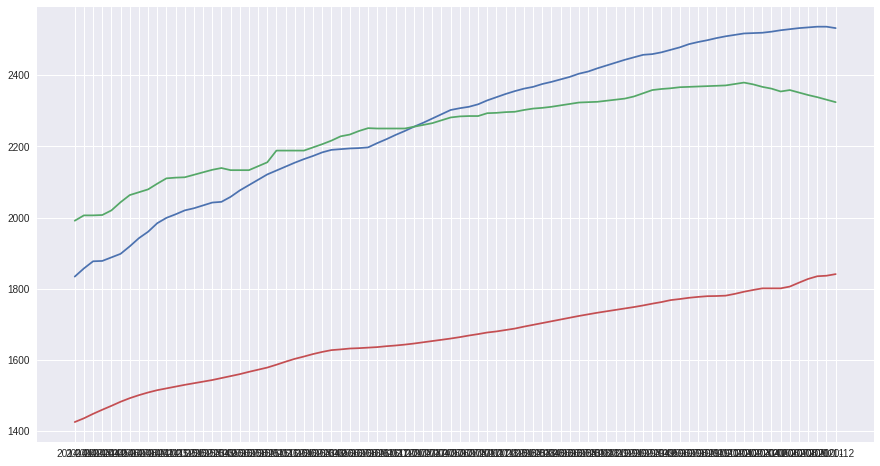

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize= (15,8))
#plt.plot(timeline, us_rent_median, label='Median')
plt.plot(monthly_array, LAmedians, label='Los Angeles Metro')
plt.plot(monthly_array, NYmedians, label='New York Metro')
plt.plot(monthly_array, Miamimedians, label='Miami-Ft.Lauderdale Metro')
plt.plot(monthly_array, USmedians, label='Overall U.S. all Zip Codes')
plt.legend(loc = 'lower center', fontsize=12)
plt.title('Median Rent Trend in Major Metro Markets', fontsize=16)
plt.xticks([11,23,35,47,59,71,83], fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Rents ($)', fontsize=12)
plt.ylim(0,3000)


Los Angeles seems to have peaked, New York is declining slightly, but Miami and the rest of the U.S. still seems to be in an upswing in rents at the end of 2020.

# Clustering

In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
scaled_rents = scaler.fit_transform(rents_drop)

In [ ]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 21):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_rents)
  silhouette_scores.append(silhouette_score(scaled_rents, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 21), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

So only 2 clusters gives us the highest silhouette score.

### KMeans

In [ ]:
# Instantiate KMeans
kmeans = KMeans(n_clusters = 2)
kmeans.fit(scaled_rents)
y_kmeans = kmeans.predict(scaled_rents)

In [ ]:
plt.scatter(scaled_rents[:, 0], scaled_rents[:, 1], c=y_kmeans, s=25, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.2);

In [ ]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled_rents)

In [ ]:
plt.figure(figsize = (8, 4))
plt.scatter(pcs[:,0], pcs[:,1], cmap='norm')
plt.title('Visualization of all of our data using the first two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2');

### Hierarchical Clustering

In [ ]:
# Visualize Dendogram
plt.figure(figsize = (15, 5))
sch.dendrogram(sch.linkage(scaled_rents, method = 'ward'))
plt.xlabel('Data Points');

In [ ]:
# Instantiate clustering
# It looks like 2 clusters may be best based on graph above
hc = AgglomerativeClustering(n_clusters = 2)
hc.fit(scaled_rents)

### DBSCAN

In [ ]:
# Instantiate & fit clustering - this is done in one step for DBSCAN
dbs = DBSCAN(eps = 0.5, min_samples = 5).fit(scaled_rents)

Silhouette Scores:

In [ ]:
for model in [kmeans, hc, dbs]:
  print('Silhouette Score for {}: {}'.format(model, silhouette_score(scaled_rents, model.labels_)))
  print('-----------------')

Looks like the KMeans model will cluster best.

Sources used for deeper uderstanding:
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

# 2019 Predictions (based on 2014-2018 data)
## Due to the massive disruption of COVID-19 in 2020 to normal markets and fluctuations, we're going to start with testing our prediction model with only actual results from 2019 for now.

# Recurring Neural Networks
RNN is a great choice for time-series modeling, which is appropriate for this dataset.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

<Figure size 864x360 with 0 Axes>

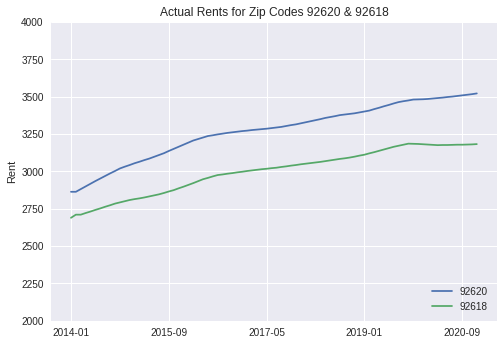

In [ ]:
#I will pick a couple random zip codes 92618 and 92620 (I know them well personally) in the Los Angeles metro market, could be any of the 165 zip codes
plt.figure(figsize = (12, 5))
LosAngeles[['92620','92618']].plot()
plt.title('Actual Rents for Zip Codes 92620 & 92618')
plt.ylabel('Rent');
plt.ylim(2000,4000)
plt.legend(loc='lower right');

In [ ]:
# Split data into training and testing - testing is year 2019
# We'll use zip code 92618 as our test model, it seems to be more representative of the region as a whole
train = np.array(LosAngeles.loc['2014-01':'2018-12', '92618'])
test = np.array(LosAngeles.loc['2019-01':'2019-12', '92618'])

In [ ]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train.reshape(-1, 1))
test = scaler.transform(test.reshape(-1, 1))

In [ ]:
# Reshape data
train_features = []
months = []
for i in range(59, train.shape[0]):
    train_features.append(train[i-59:i, 0])
    months.append(train[i, 0])

In [ ]:
# convert to arrays and reshape
train_features, months = np.array(train_features), np.array(months)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)

In [ ]:
# Step 1: Define our network structure
# Save the input shape
input_shape = train_features.shape[1:3]
input_shape

(59, 1)

In [ ]:
# Sequential model
model = Sequential()

In [ ]:
# LSTM layer
model.add(LSTM(units = 50, 
               return_sequences = True, # True if next layer will be a recurrent layer
               input_shape = input_shape))
model.add(LSTM(units = 50, 
               return_sequences = True))
model.add(LSTM(units = 50, 
               return_sequences = False))
# Output layer
model.add(Dense(units = 1, activation = 'linear'))

In [ ]:
# Step 2: Compile
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
# Step 3: Fit our model
history = model.fit(train_features, months, 
                    epochs=100)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.0165
Epoch 2/100
1/1 [==============================] - 0s 56ms/step - loss: 0.8235
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 0.6409
Epoch 4/100
1/1 [==============================] - 0s 54ms/step - loss: 0.4573
Epoch 5/100
1/1 [==============================] - 0s 64ms/step - loss: 0.2717
Epoch 6/100
1/1 [==============================] - 0s 76ms/step - loss: 0.1032
Epoch 7/100
1/1 [==============================] - 0s 66ms/step - loss: 0.0043
Epoch 8/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0490
Epoch 9/100
1/1 [==============================] - 0s 64ms/step - loss: 0.1394
Epoch 10/100
1/1 [==============================] - 0s 76ms/step - loss: 0.1407
Epoch 11/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0884
Epoch 12/100
1/1 [==============================] - 0s 70ms/step - loss: 0.0344
Epoch 13/100
1/1 [==============================] -

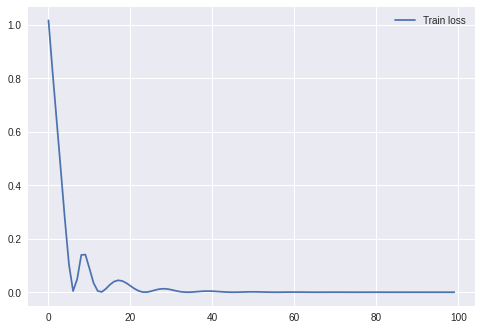

In [ ]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

In [ ]:
full = np.concatenate((train, test))

In [ ]:
test_months = pd.DataFrame(full)[len(full) - len(test) - 59:].values
# Get previous 59 months to use as features
test_features = []
for i in range(59, 71):
    test_features.append(test_months[i-59:i, 0])
# Reshape
test_features = np.array(test_features)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [ ]:
preds = model.predict(test_features)

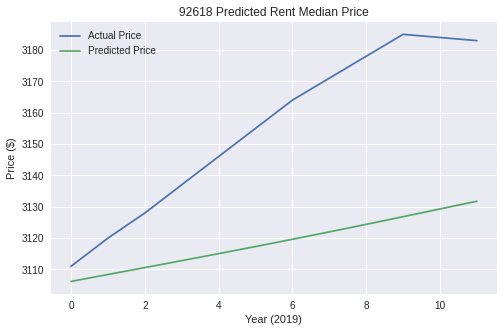

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(scaler.inverse_transform(test), label='Actual Price')
plt.plot(scaler.inverse_transform(preds), label='Predicted Price')
plt.title('92618 Predicted Rent Median Price')
plt.xlabel('Year (2019)')
plt.ylabel('Price ($)')
plt.legend();

## Clearly one year isn't a large enough testing size... so despite COVID-19, let's use the data from 2020 as well to test our predictions.

# 2020 Predictions (based on 2014-2018 data)
We still used the same 2014-2018 data (60 months' worth) but now we're predicting the rent for the 24 months of 2019 AND 2020.  We'll use a sample zip code (92618) in the L.A. market for now.

In [ ]:
# Split data into training and testing - testing is year 2019
train = np.array(LosAngeles.loc['2014-01':'2018-12', '92618'])
test = np.array(LosAngeles.loc['2019-01':'2020-12', '92618'])

In [ ]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train.reshape(-1, 1))
test = scaler.transform(test.reshape(-1, 1))

In [ ]:
# Reshape data
train_features = []
months = []
for i in range(59, train.shape[0]):
    train_features.append(train[i-59:i, 0])
    months.append(train[i, 0])

In [ ]:
# convert to arrays and reshape
train_features, months = np.array(train_features), np.array(months)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)

In [ ]:
# Step 1: Define our network structure
# Save the input shape
input_shape = train_features.shape[1:3]
input_shape

(59, 1)

In [ ]:
# Sequential model
model = Sequential()

In [ ]:
# LSTM layer
model.add(LSTM(units = 50, 
               return_sequences = True, # True if next layer will be a recurrent layer
               input_shape = input_shape))
model.add(LSTM(units = 50, 
               return_sequences = True))
model.add(LSTM(units = 50, 
               return_sequences = False))
# Output layer
model.add(Dense(units = 1, activation = 'linear'))

In [ ]:
# Step 2: Compile
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
# Step 3: Fit our model
history = model.fit(train_features, months, 
                    epochs=100)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.8885
Epoch 2/100
1/1 [==============================] - 0s 56ms/step - loss: 0.6879
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 0.4894
Epoch 4/100
1/1 [==============================] - 0s 65ms/step - loss: 0.2915
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 0.1123
Epoch 6/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0049
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0580
Epoch 8/100
1/1 [==============================] - 0s 63ms/step - loss: 0.1485
Epoch 9/100
1/1 [==============================] - 0s 60ms/step - loss: 0.1278
Epoch 10/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0627
Epoch 11/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0147
Epoch 12/100
1/1 [==============================] - 0s 59ms/step - loss: 2.6253e-06
Epoch 13/100
1/1 [=============================

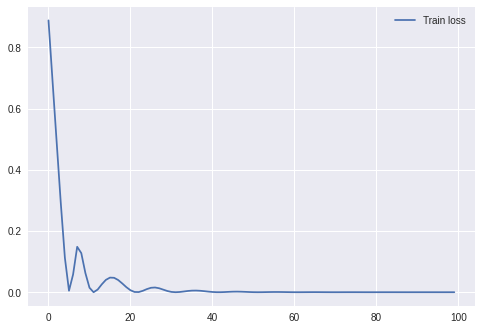

In [ ]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

In [ ]:
full = np.concatenate((train, test))

In [ ]:
test_months = pd.DataFrame(full)[len(full) - len(test) - 59:].values
# Get previous 59 months to use as features
test_features = []
for i in range(59, 83):
    test_features.append(test_months[i-59:i, 0])
# Reshape
test_features = np.array(test_features)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

In [ ]:
preds = model.predict(test_features)

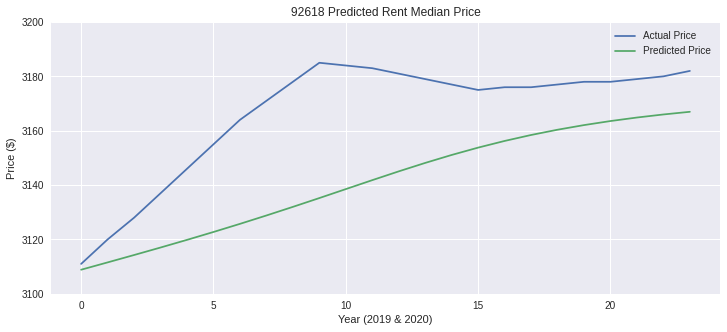

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(scaler.inverse_transform(test), label='Actual Price')
plt.plot(scaler.inverse_transform(preds), label='Predicted Price')
plt.title('92618 Predicted Rent Median Price')
plt.xlabel('Year (2019 & 2020)')
plt.ylabel('Price ($)')
plt.ylim(3100,3200)
plt.legend();

## Summary: 
Pretty close machine prediction accuracy for future predictions, despite the chaotic year of 2020!

# 2020 Predictions for the whole L.A. market
We still used the same 2014-2018 data (60 months' worth) but now we're predicting the rent for the 24 months of 2019 AND 2020.

In [ ]:
# Split data into training and testing - testing is year 2019
trainLA = np.array(LAmedians[0:60])
testLA = np.array(LAmedians[60:84])
trainLA

array([1834., 1857., 1877., 1878., 1888., 1898., 1919., 1942., 1960.,
       1984., 1999., 2009., 2020., 2026., 2034., 2042., 2044., 2058.,
       2076., 2091., 2106., 2121., 2132., 2143., 2154., 2164., 2173.,
       2183., 2190., 2192., 2194., 2195., 2197., 2209., 2220., 2232.,
       2243., 2255., 2266., 2278., 2290., 2302., 2307., 2311., 2318.,
       2329., 2338., 2347., 2355., 2362., 2367., 2375., 2381., 2388.,
       2395., 2404., 2410., 2419., 2427., 2435.])

In [ ]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))
trainLA = scaler.fit_transform(trainLA.reshape(-1, 1))
testLA = scaler.transform(testLA.reshape(-1, 1))

In [ ]:
# Reshape data
train_featuresLA = []
monthsLA = []
for i in range(59, trainLA.shape[0]):
    train_featuresLA.append(trainLA[i-59:i, 0])
    monthsLA.append(trainLA[i, 0])

In [ ]:
# convert to arrays and reshape
train_featuresLA, monthsLA = np.array(train_featuresLA), np.array(monthsLA)
train_featuresLA = train_featuresLA.reshape(train_featuresLA.shape[0], train_featuresLA.shape[1], 1)

In [ ]:
# Step 1: Define our network structure
# Save the input shape
input_shapeLA = train_featuresLA.shape[1:3]
input_shapeLA

(59, 1)

In [ ]:
# Sequential model
modelLA = Sequential()

In [ ]:
# LSTM layer
modelLA.add(LSTM(units = 50, 
               return_sequences = True, # True if next layer will be a recurrent layer
               input_shape = input_shapeLA))
modelLA.add(LSTM(units = 50, 
               return_sequences = True))
modelLA.add(LSTM(units = 50, 
               return_sequences = False))
# Output layer
modelLA.add(Dense(units = 1, activation = 'linear'))

In [ ]:
# Step 2: Compile
modelLA.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
# Step 3: Fit our model
historyLA = modelLA.fit(train_featuresLA, monthsLA, 
                    epochs=100)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.9790
Epoch 2/100
1/1 [==============================] - 0s 65ms/step - loss: 0.7777
Epoch 3/100
1/1 [==============================] - 0s 55ms/step - loss: 0.5893
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 0.4018
Epoch 5/100
1/1 [==============================] - 0s 63ms/step - loss: 0.2167
Epoch 6/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0603
Epoch 7/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0017
Epoch 8/100
1/1 [==============================] - 0s 60ms/step - loss: 0.1120
Epoch 9/100
1/1 [==============================] - 0s 69ms/step - loss: 0.1632
Epoch 10/100
1/1 [==============================] - 0s 62ms/step - loss: 0.1090
Epoch 11/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0404
Epoch 12/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0045
Epoch 13/100
1/1 [==============================] -

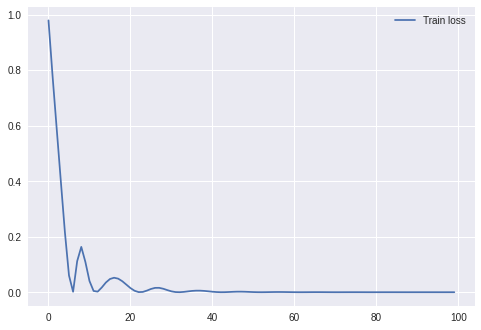

In [ ]:
# Visualize the loss
plt.plot(historyLA.history['loss'], label='Train loss')
plt.legend();

In [ ]:
fullLA = np.concatenate((trainLA, testLA))

In [ ]:
test_monthsLA = pd.DataFrame(fullLA)[len(fullLA) - len(testLA) - 59:].values
# Get previous 59 months to use as features
test_featuresLA = []
for i in range(60, 83):
    test_featuresLA.append(test_monthsLA[i-59:i, 0])
# Reshape
test_featuresLA = np.array(test_featuresLA)
test_featuresLA = test_featuresLA.reshape(test_featuresLA.shape[0], test_featuresLA.shape[1], 1)

In [ ]:
predsLA = modelLA.predict(test_featuresLA)

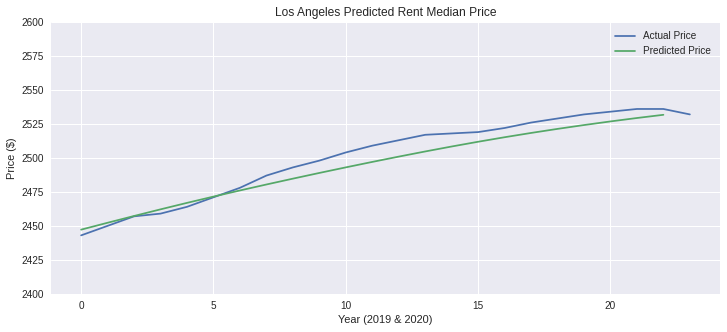

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(scaler.inverse_transform(testLA), label='Actual Price')
plt.plot(scaler.inverse_transform(predsLA), label='Predicted Price')
plt.title('Los Angeles Predicted Rent Median Price')
plt.xlabel('Year (2019 & 2020)')
plt.ylabel('Price ($)')
plt.ylim(2400,2600)
plt.legend();

Cool!  When predicting the LA market as a whole, the model was a bit more conservative, underestimating the actual rent price increase to come from end of 2018 to end of 2020, but still ended up very close to actual! Looks like the median of all 165 LA metro area zips modeled about the same as my prior single sample.

### The next step would be to take the actual results of these 7 years' worth of data and use the model to predict the next 24 months' worth of rent prices.